![](./kkbox_picture.jpg)


The 11th ACM International Conference on Web Search and Data Mining (WSDM 2018) is challenging you to build a better music recommendation system using a donated dataset from KKBOX. WSDM (pronounced "wisdom") is one of the the premier conferences on web inspired research involving search and data mining. They're committed to publishing original, high quality papers and presentations, with an emphasis on practical but principled novel models.

---
音樂推薦最好的方式除了structure data的log記錄之外, 最好也能夠分析音樂檔(binary files), 不過一首歌的binary檔案大小就已經很大, 我想很少有公開的open data能夠這樣提供資料, 這裡我們就針對member hitory去預測是否該會員喜歡某一首歌曲, 至於喜歡的定義在[Kaggle KKBOX Music Recommendation](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data)上有解說

---
這裡我們會時做一般的DNN(Dense layer) model, 也叫做fully connected layer, 也會實作[Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf)這篇論文發表的架構, 並做個比較, 另外我們也大量使用embedding向量平均的功能, 類似[tf.feature_column.embedding_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)的combiner功能.

---
## Flow

這邊主要會先展示EDA(Explotary Data Analysis), 再來是解釋Model以及如何training, 最後比較model成效

---
## What kind of problem to solve?

Click Throgh Rate(CTR) like or Classification problem

In [45]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time, html
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns

from sklearn import preprocessing
from collections import defaultdict, Counter, OrderedDict
from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer.utils import utils, utils_nb
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Preview

### train.csv
Column | Description
--:--  | --:-- 
msno | user id
song_id | song id
source_system_tab | the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name | name of the layout a user sees.
source_type | an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target | this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
<br/>

## songs.csv
Column | Description
--:--  | --:-- 
song_id | 
song_length | in ms
genre_ids | genre category. Some songs have multiple genres and they are separated by
artist_name | 
composer | 
lyricist | 
language |
<br/>

## members.csv
Column | Description
--:--  | --:-- 
msno | 
city | 
bd | age. Note: this column has outlier values, please use your judgement.
gender | 
registered_via | registration method
registration_init_time | format %Y%m%d
expiration_date | format %Y%m%d

## song_extra_info.csv
Column | Description
--:--  | --:-- 
song_id | 
song name | the name of the song.
isrc | International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [2]:
utils.preview('./data/train.csv')

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
utils.preview('./data/test.csv')

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [4]:
utils.preview('./data/members.csv')

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
utils.preview('./data/songs.csv')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
utils.preview('./data/song_extra_info.csv')

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


## Data Exploration
#### 簡單針對幾點去探勘資料
Recommendation的資料是針對個人的探討, 這裡的Exploration只能夠針對一般性的Feature (e.g: `gender`, `city`, `age` ...) 去觀察是否有特殊的Information

- 歌曲的受歡迎程度是否和`target`有顯著的關係(Pearson Coefficient)
- 會員和歌曲的互動關係(當然我們不會探討所有組合)
    - 單變數(uni-variate): [`bd` + `gender` + `city` + `tenure`] X [`song_yy` + `language` + `song_length`]
    - 多變數欄位(multi-ivariate): [`bd` + `gender` + `city` + `tenure`] X [`genre_ids` + `artist_name` + `composer`]



In [3]:
%%time
_ = inp.Input.instance.clean('./data/train.csv')

2018-08-12 12:18:20,126 - trainer.input - INFO [line:30] - Clean start, is_serving: False
2018-08-12 12:18:43,518 - trainer.input - INFO [line:48] - Clean table members.
2018-08-12 12:18:44,122 - trainer.input - INFO [line:59] - Clean table songs.
2018-08-12 12:19:44,958 - trainer.input - INFO [line:78] - Clean take time 0:01:24.830091
Wall time: 1min 25s


## 增加Features
- 使用`registration_init_time`和`expiration_date`算出member的`租期`(`tenure`)
- 將年齡欄位`bd`切割為多個級距 ==> '06-10', '10-20', '20-30', '30-40', '40-60', '60-80'
- 從`isrc`欄位萃取出歌曲年分`song_yy`
- 算出歌曲本身的受歡迎程度`song_clicks`, `song_pplrty`

In [5]:
%%time
members = pd.read_pickle('./data/processed/cleaned/members.pkl')
# Rounding tenure to int and fill missing value with median
members['tenure'] = ((members.expiration_date - members.registration_init_time) / 365).round()
members['tenure'] = members.tenure.fillna( members.tenure.median() ).map(int)
bins = np.array([6, 10, 20, 30, 40, 60, 80])
age_map = pd.Series(['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80', ''])
members['msno_age_catg'] = pd.Series(np.digitize(members.bd, bins)).map(age_map)


songs = pd.read_pickle('./data/processed/cleaned/songs.pkl')
song_extra_info = pd.read_csv('./data/song_extra_info.csv').set_index('song_id')
# Although we don't put name feature for training, but it's good for exploration 
songs['name'] = song_extra_info.name.reindex(songs.song_id).values
songs['song_yy'] = (songs.isrc.str.slice(5, 7)
                         .map(lambda e: 2000 + int(e) if int(e) < 18 else 1900 + int(e), 
                              na_action='ignore'))
# Transform song_yy to songs age
age_bins = pd.Series([0, 1960, 1980, 1990, 2000, 2010, 2015])
age_map = pd.Series([0, 1960, 1980, 1990, 2000, 2010, 2015, 2018])
songs['song_yy'] = (pd.Series(np.digitize(songs.song_yy.fillna(-1), age_bins))
                      .map(age_map).map(str))

del song_extra_info

Wall time: 26.7 s


In [4]:
%%time
tr = pd.read_pickle('./data/processed/cleaned/tr.pkl')
vl = pd.read_pickle('./data/processed/cleaned/vl.pkl')
data = pd.concat([tr, vl], 0, ignore_index=True).merge(members, how='left', on='msno').merge(songs, how='left', on='song_id')
del tr, vl 

# Songs popularity and clicks
basic_stats = data.groupby('song_id').target.agg(['count', 'mean'])
basic_stats['song_clicks'] = basic_stats.pop('count')
basic_stats['song_pplrty'] = basic_stats.pop('mean')
basic_stats = basic_stats.reindex(data.song_id)
data['song_clicks'] = basic_stats.song_clicks.values
data['song_pplrty'] = basic_stats.song_pplrty.values
data['tenure'] = data.tenure.fillna(2)
# 
data = data[data.song_id.isin(songs.song_id) & data.msno.isin(members.msno)]
del basic_stats

Wall time: 19.3 s


In [5]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,genre_ids,artist_name,composer,lyricist,language,isrc,name,song_yy,song_clicks,song_pplrty
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,UM5K+g04+9t1SULpbhMfEunp6bS/5AdIQs7FbDqmmBY=,radio,Radio,radio,0,1,0,,7,...,"(359,)","(Death Cab for Cutie,)","(Benjamin Gibbard,)","(Benjamin Gibbard,)",52,USAT20900521,Little Bribes,2010,13,0.000
1,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,O9ENbN0pn9UhrPpliLKdL6NbJXvr8ne4gDPEtWiCRaw=,radio,Radio,radio,0,1,0,,7,...,"(465,)","(OneRepublic,)","(Jerrod Bettis, Ryan Tedder, Tim Myers, Zachar...","(,)",52,USUM70758801,Prodigal,2010,17,0.235
2,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,8xLXY8xKz3fcOcah+0zEMWho1OprmBalG4MgT/MFbDA=,radio,Radio,radio,0,1,0,,7,...,"(359,)","(The Killers,)","(Brandon Flowers, Dave Keuning, Mark Stoermer,...","(,)",52,USUM70842812,The World We Live In,2010,8,0.000
3,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,J6PLzbPghqmmBEbwHqz83SWKV8rxdjxFop2yT3Ch+CA=,radio,Radio,radio,0,1,0,,7,...,"(465,)","(The Script,)","(,)","(,)",52,GBARL1201146,Glowing,2015,30,0.300
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Y77QSQoIkWtNb9LJISA3EbBzReKMRUCsDeWkzoe/fvA=,search,Search,online-playlist,0,1,0,,7,...,"(465,)","(Pharrell Williams,)","(Pharrell Williams,)","(Pharrell Williams,)",52,USSM11400861,Come Get It Bae,2015,36,0.417


In [29]:
(members.msno_age_catg == '').sum() / len(members.msno_age_catg)

0.5805017004331018

年齡`(msno_age_catg)`的missing value已經超過50%, 理當要drop這個feature, 但是人類聽歌的行為跟年齡有應該非常大的關係, 我們仍然保留住這個feature, 之後會再探討.

<br/>
<br/>
<br/>

## 歌曲的受歡迎程度是否和target有顯著的關係(Pearson Coefficient)

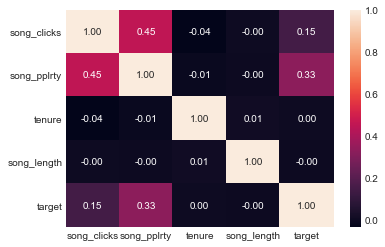

In [6]:
sns.heatmap(data[['song_clicks', 'song_pplrty', 'tenure', 'song_length', 'target']].corr(), annot=True, fmt='.2f')

照理說Pearson Coefficient只能套用在連續變數, 但是target欄位`0, 1`可以代表著喜好程度, 有這大小關係, 所以我們仍然可以看出資料趨勢
- `song_pplrty`跟`target`有些許的正向關係 ==> 意味著推薦受歡迎歌曲命中率較高, 這是可預料的事情
- `song_pplrty`, `song_clicks`有些許的正向關係

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## 會員和歌曲的互動關係(單變數)

In [7]:
# stats = utils_nb.flatten(data, ['song_yy', 'msno_age_catg', 'language'], 'genre_ids', 'target')
# 單變數(uni-variate): [bd + gender + city + tenure] X [song_yy + language + song_length]
stats = data[['msno_age_catg', 'gender', 'city', 'tenure', 'song_yy', 'language', 'song_length', 'target']].copy()
stats.head()

,msno_age_catg,gender,city,tenure,song_yy,language,song_length,target
0,,,1,6,2010,52,167026.000,0
1,,,1,6,2010,52,235078.000,0
2,,,1,6,2010,52,278453.000,0
3,,,1,6,2015,52,286487.000,0
4,,,1,6,2015,52,202040.000,0


### 年齡`msno_age_catg` and 歌曲年分`song_yy`

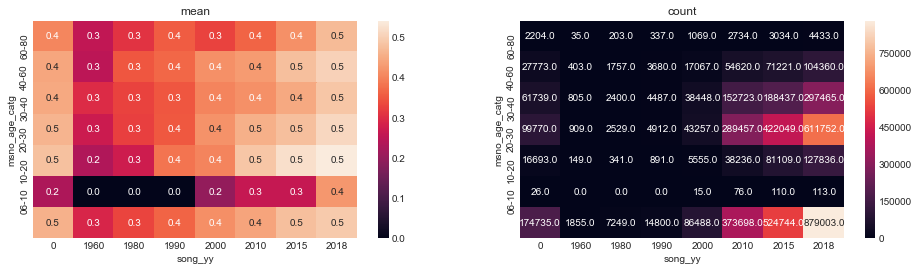

In [15]:
age_tick = ['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80']

# Remove
chop = stats # .query("msno_age_catg != '' and song_yy != '0'")
utils_nb.heatmap(chop, 'msno_age_catg', 'song_yy', annot=True, ytick=sorted(age_tick, reverse=True), fmt='.1f')

### 年齡`msno_age_catg` and 歌曲語言`language`

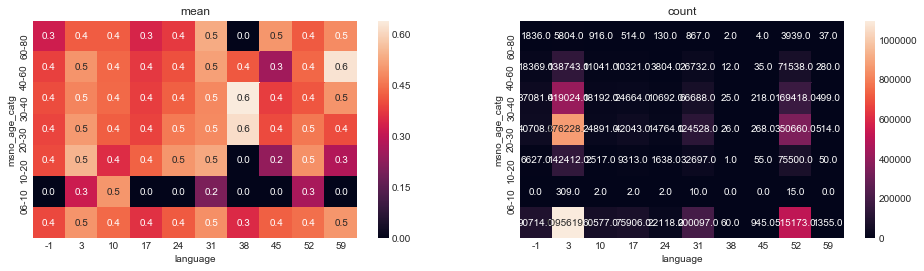

In [21]:
chop = stats # .query("msno_age_catg != ''")
utils_nb.heatmap(chop, 'msno_age_catg', 'language', annot=True,
                 xtick=('-1', '3', '10', '17', '24', '31', '38', '45', '52', '59'),
                 ytick=sorted(age_tick, reverse=True), fmt='.1f')

### Observation
- `song_yy = 0` 為不知年份的歌曲, 是missing value, 所以沒辦法做任何評論
- 總體來看, 年齡20 ~ 30歲的人數最多, 這在預料之中
- 歌曲年份越新越受歡迎, 不管年齡層(排除`song_yy` = 0的部分)
- 以1960年代以前的歌曲, 高年齡層的人偏愛的程度比其他年份多一些, 但趨勢上不是強烈的顯著, 畢竟因為高年齡使用人數太少
- `language = 3` 的人數是最多的, 喜好的程度也很高, KKBOX是華語為主的音樂平台, 可大膽猜測`language 3`應該是華語類, 從songs table查詢也確實如此

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### 年齡`msno_age_catg` and 歌曲年分`song_yy` + 歌曲語言`language`

language = -1


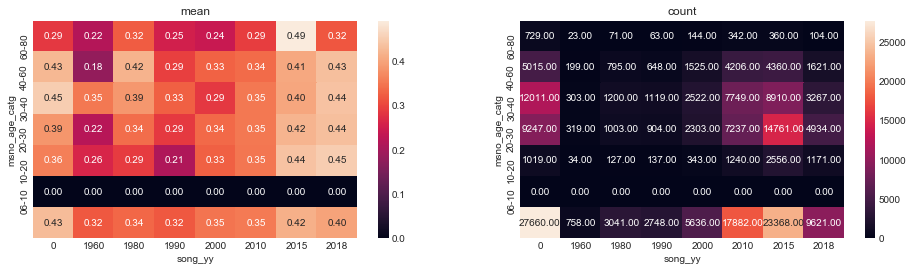

language = 3


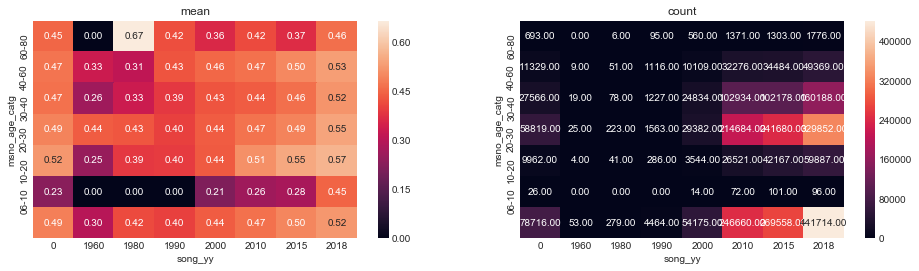

language = 10


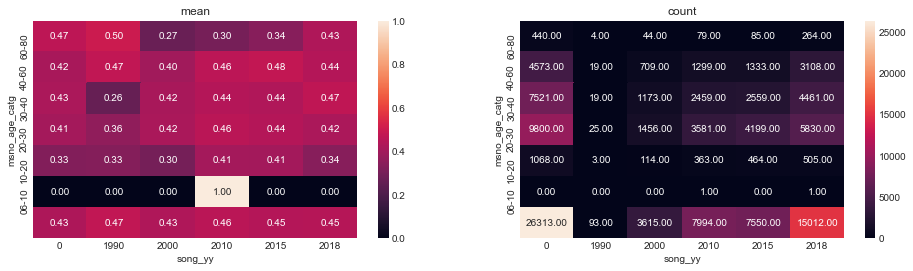

language = 17


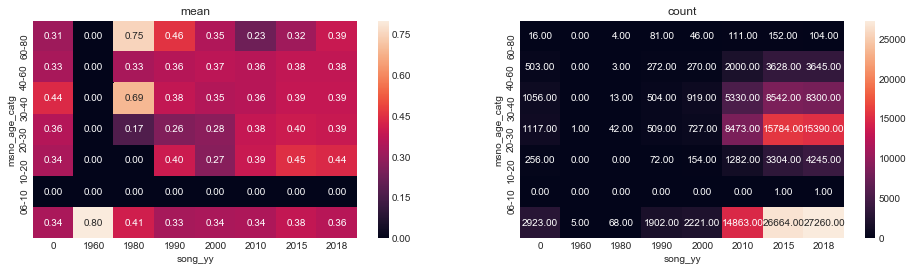

language = 24


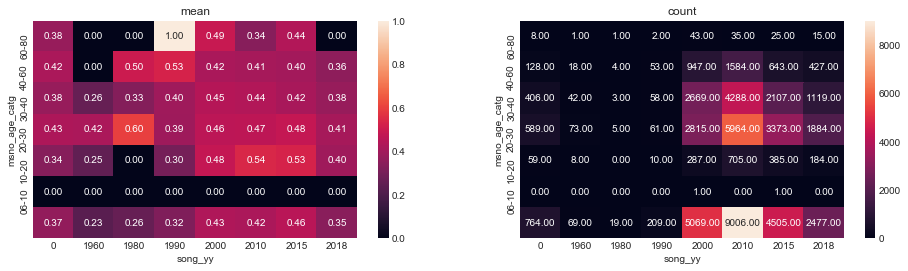

language = 31


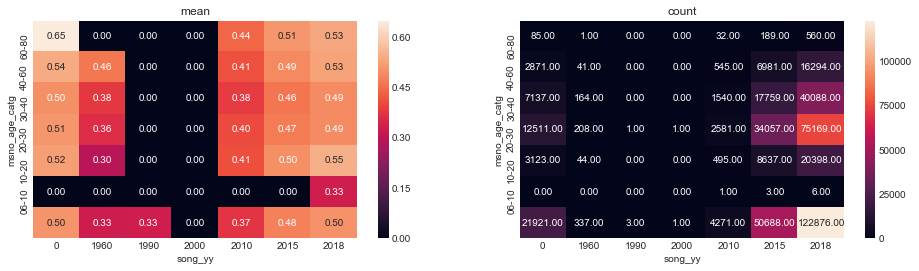

language = 38


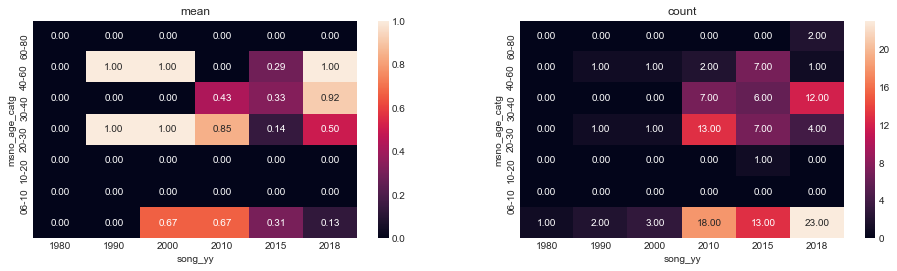

language = 45


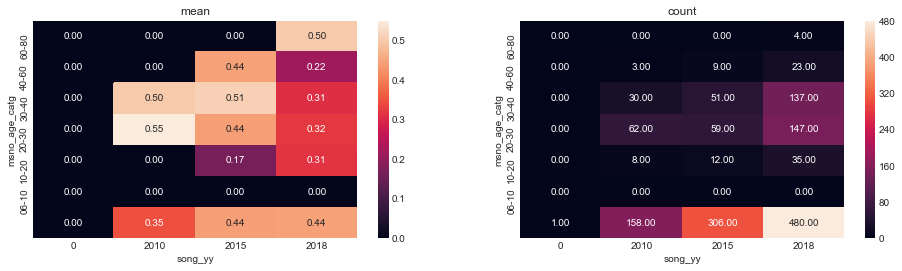

language = 52


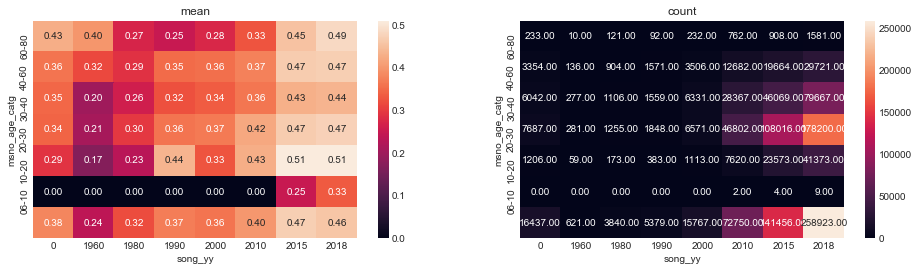

language = 59


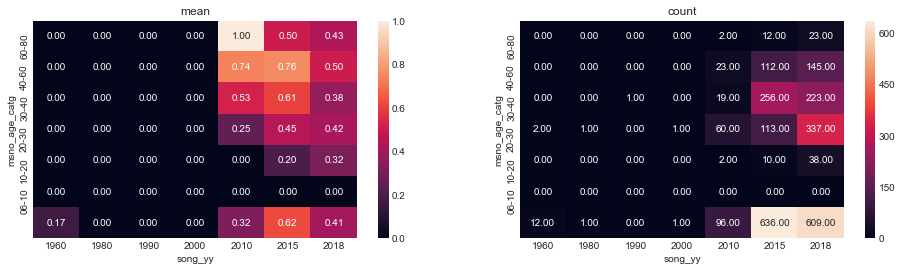

In [22]:
chop = stats # .query("msno_age_catg != '' and song_yy != '0'")
for lan in ('-1', '3', '10', '17', '24',  '31', '38', '45', '52', '59'):
    print(f'language = {lan}')
    utils_nb.heatmap(chop.query(f"language == '{lan}'"), 'msno_age_catg', 'song_yy', annot=True, ytick=sorted(age_tick, reverse=True), fmt='.2f')

### Observation (自動忽略數量太少的部分)
- `language = 17`是日語歌, 1980年代的歌曲在`30-40`, `60~80`歲平均有增高, 也許和台灣日據時期有些關係
- `language = 31`是韓文歌, 1960年代以前的歌曲有顯著的分布, 篇好的年齡族群是高年齡層
- `language = 45`是泰文歌, 沒有2010以前的年分的聽歌紀錄(但是songs table裡面是有的)
- `language = 24`的點擊數集中在2010年分, 從songs table可知是香港歌曲(這似乎有什麼特殊原因), `language = 38`似乎也是如此, 但是數量太少所以不認為是顯著的
---
<br/>
<br/>

- 原本認為聽歌習慣會停留在20 ~ 40歲之間, 聽老歌的人年齡層就會高一點, 但是觀察這方面並不是太顯著(但在`language = 17`日文歌有些許顯著), 也許歌曲年分`song_yy`和會員年齡`bd`(`msno_age_catg`) missin value太多有關係
- 歌曲本身語言影響是很顯著的, 是重要的feature


<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### 性別`gender` + 城市`city` and 歌曲年分`language` 

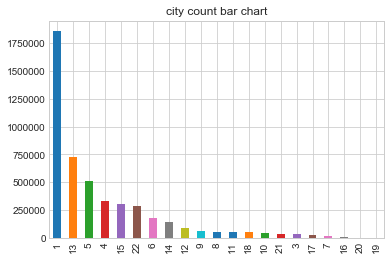

In [100]:
chop = stats.copy() # query("gender != ''")

chop.city.value_counts().plot.bar(title='city count bar chart')

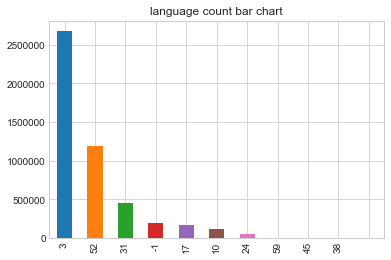

In [101]:
chop.language.value_counts().plot.bar(title='language count bar chart')

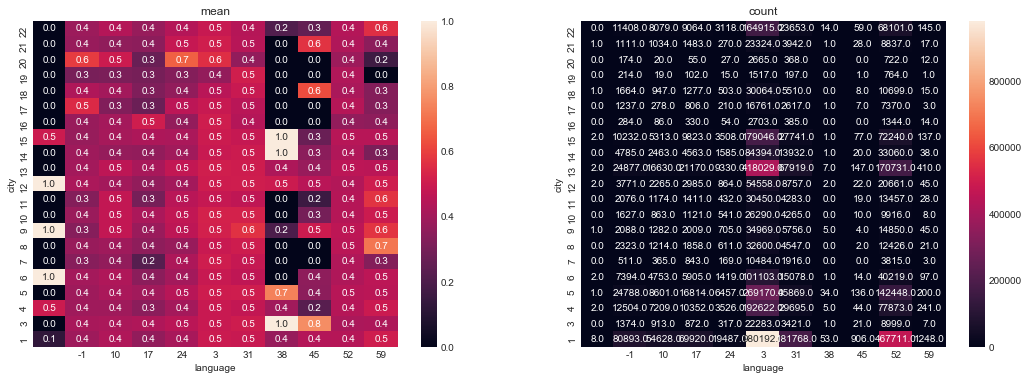

Gender: 


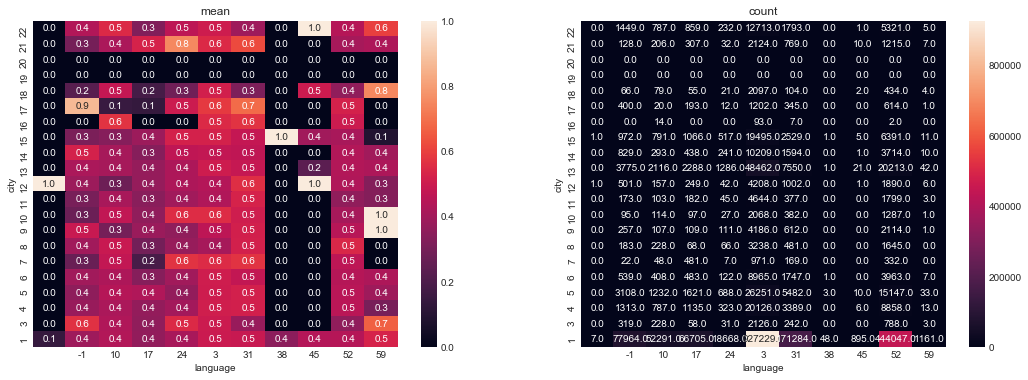

Gender: male


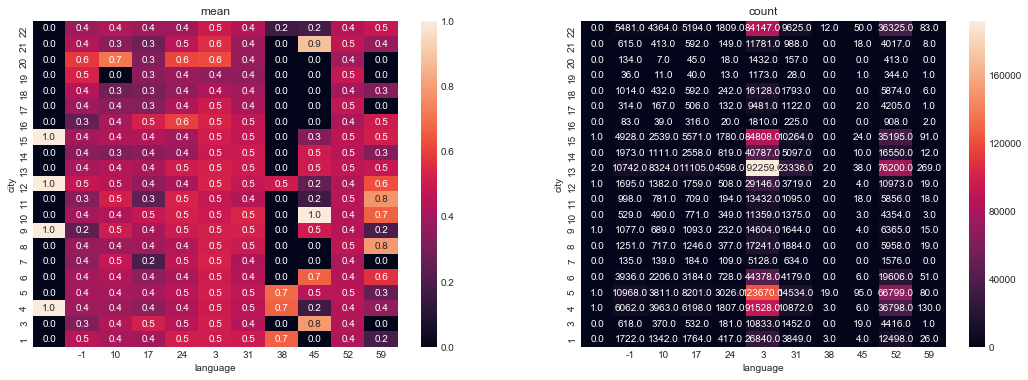

Gender: female


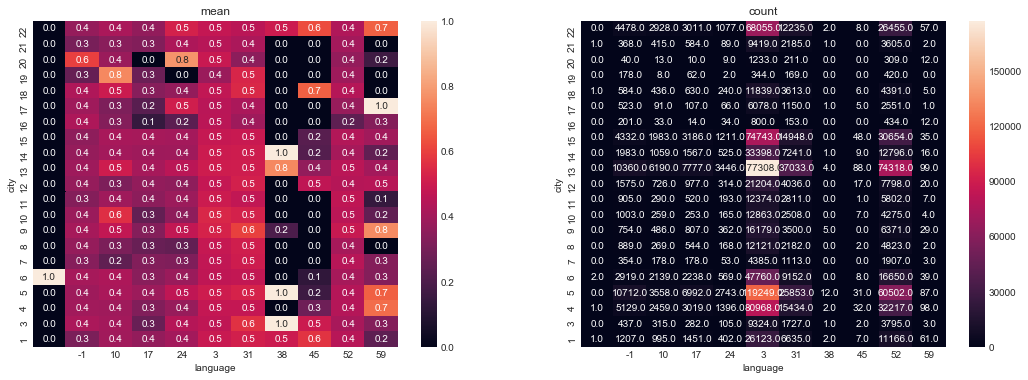

In [25]:
city_tick = list( map(str, sorted(map(int, chop.city.unique()))) )
city_tick.reverse()
utils_nb.heatmap(chop, 'city', 'language', annot=True, fmt='.1f', ytick=city_tick, figsize=(18, 6))

for gd in ('', 'male', 'female'):
    print(f'Gender: {gd}')
    utils_nb.heatmap(chop.query(f"gender == '{gd}'"), 'city', 'language', annot=True, fmt='.1f', ytick=city_tick, figsize=(18, 6))

### Observation
1. `city = 1`的使用人數是最多的, 至於mean的heatmap有顯著的部分都是數量太少的情況, 不是有用的information
2. `city`和`language`的頻率分布都是不平均的, 至少這一點在分布上算是顯著的information

<br/>
<br/>
<br/>

### 以歌曲類別`genre_ids`為主, 因為種類眾多, 只觀察點擊量在2萬以上的genres

In [26]:
stats_genres = utils_nb.flatten(data, ['msno_age_catg', 'gender', 'city', 'tenure', 'song_yy', 'language', 'song_length'], 'genre_ids', 'target')
stats_genres.head()

,msno_age_catg,gender,city,tenure,song_yy,language,song_length,genre_ids,target
0,,,1,6,2010,52,167026.000,359,0
1,,,1,6,2010,52,235078.000,465,0
2,,,1,6,2010,52,278453.000,359,0
3,,,1,6,2015,52,286487.000,465,0
4,,,1,6,2015,52,202040.000,465,0


In [30]:
genre_vc = stats_genres.genre_ids.value_counts()
print( genre_vc.describe() )

count       164.000
mean      31159.537
std      208234.426
min           1.000
25%          17.750
50%         105.500
75%        2808.000
max     2482788.000
Name: genre_ids, dtype: float64


genre_ids x msno_age_catg


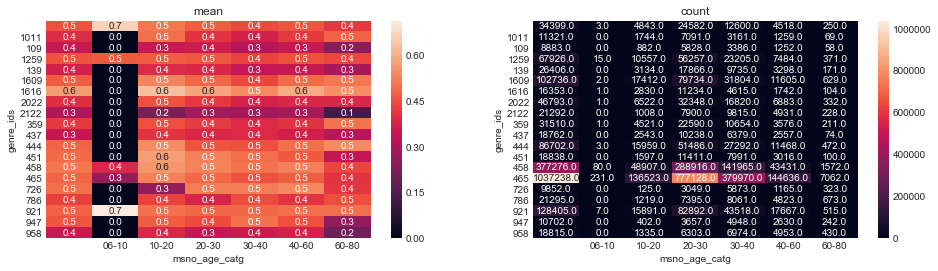

genre_ids x city


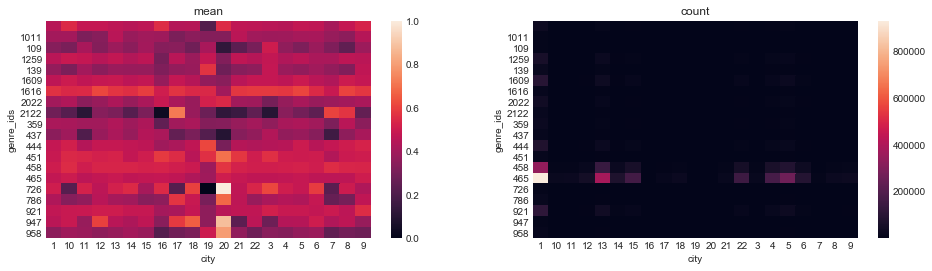

genre_ids x song_yy


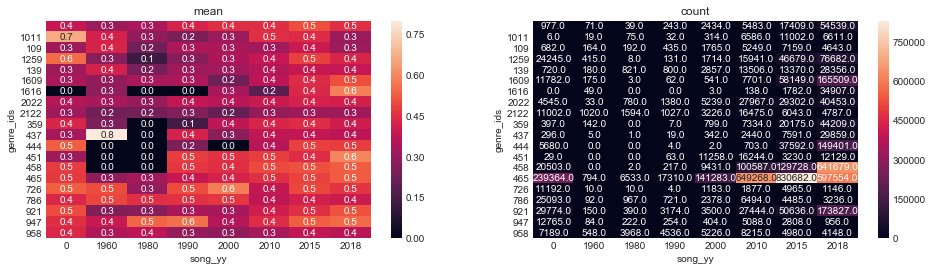

genre_ids x language


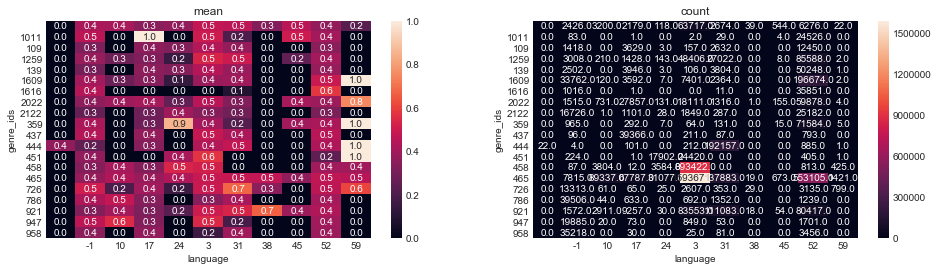

In [32]:
chop = stats_genres # .query("genre_ids != '' and msno_age_catg != ''")
genre_vc = chop.genre_ids.value_counts()
genre_vc = genre_vc[genre_vc >= 20000].index.values
print(f'genre_ids x msno_age_catg')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'msno_age_catg', annot=True, 
                 xtick=['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80'], 
                 fmt='.1f')

print(f'genre_ids x city')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'city', annot=False, 
                 fmt='.1f')

print(f'genre_ids x song_yy')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'song_yy', annot=True, 
                 fmt='.1f')

print(f'genre_ids x language')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'language', annot=True, 
                 fmt='.1f')

### Observation
- `genre_ids x msno_age_catg`: 基本上除了數量集中在 `genre = 465, 458` 是顯著的, 偏好的部分平均分布, 除了`60-80`歲的族群似乎不太喜歡`genre = 2122`的歌曲
- `genre_ids x city`: 無顯著資訊
- 歌曲本身資訊:
    - `genre_ids x song_yy`, `genre_ids x language`: 無顯著資訊
    
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Multivariate多元變數互動

在做多變數EDA之前我們先觀察一下`genre_ids, artist_name, composer, lyricist`4個以`|`分隔的字串, 預計會有一些outliter


In [24]:
def inspect_multi(m_col):
    ary = []
    songs[m_col].map(ary.extend)
    ary = pd.Series(ary)
    idxmax = ary.map(len).sort_values(ascending=False)[:10].index.values
    print(ary[idxmax[0]])
    
inspect_multi('artist_name')

Bernard Edwards Jr. 52 5utiLF7fh05rToE50YnkvuEOsKhJmQLxWh1w2qYKhnA 343666 Linda Ronstadt 52 sIstoLt134OfZXyetCoUqBuDas1he9uZot5EkFdp7 o 183771 921 Various Artists 52 mv3ghJbCnLEe5gEKfog 0tf8V847RpdGu1HMQKvzENc 84056 873 Reverend Lucas Noth 1 xXBADsUSxnr3UeJsjjYYGvG4xo3OCvAf HP6vgXJDq0 373307 139 Quincy Jones Rod Temperton 52 3IS9BYln6m wTPwHfZ8Msb7Cw14PjmdYKmE2l3ZL204 395389 465 Camille Camille Dalmais 52 LIWXgrPZvxwnvNwfIVaDqx4 Q4ixShpBwpoGXe4uW00 818039 958 Cyprien Katsaris 1 U B6mvGCijGdIrX6K k6uynCvdXdCRsFL8ITv k1LU 269630 465 Mega M. Nasir 59 wa9zqcTRE8wj8 IgOWg00Yg42SZmbwZzqII69kIhAAg 267493 Silent Storm 52 hwypn1FlbC9w2XJ0BPQvupKB2QzZXDvvijBPk jgy78 63251 726 Kids Choir Traditional 1 oeu8bxfD8jj SrAb1Lo9S8MxXl2IQ1SvLwnXCBGLToA 314398 2022 Thompson Teddy Thompson 52 PUxmHjMe3yH3diTS tBdjvp4Q4w8EHuV2LBCqMVECoY 183301 1609 Cameo Culture David Robertson 52 RnHUXHvDgDYh7 gCOnTrOadi6SxGs3xE 04Brp8k8o 181681 242 Chart Topping Karaoke 1 hz2hWE 2e3l6yHOmjggnWnM1i fAGSnubKGClopqZzs 170434

In [25]:
inspect_multi('composer')

Sebastian Ingrosso 52 WKCEUOm70 9O7IQ3VE2ohtiJaDGUH7cChanz4plSdA 306886 465 曹格 Gary Chaw 曹格 姚若龍 等人 3 SOicQ4b0ieAafeGqjdGVU5MPAgtYlCfGi6P49 le65I 409600 139 Slave 52 cuSwXYNpWOTM1drx mJW3qM0P5b5TY44xtrIP8DoGzQ 287093 465 J 17 I4p6lOJx ZlqcVWD5AncdwaLGfhLJ7eqm 38rSTGLjc 239281 458 于小冉 Qxygen F1ST 基械貓 3 SxekcRFJ l4MWpWZhkTsEfD0bLRpqAGZ1Y2Ed1tJ3DY 206836 465 李治廷 Aarif Rahman 李治廷 張楚翹 Solid Sound 陳考威 SpingWo 3 Dh1uPET9CjT916QXnHI1oUhnwB306jFJ xemOyU LYs 392510 2022 Megadeth Dave Mustaine 52 uQpEdgHWBjo1R8 AXlzxvzWn0Jj0jJLlpBfxi TZK00 56982 958 Peter Serkin Johann Sebastian Bach 1 QGch6e8vfa5uh7d9FvwiMpvL2SeGE0njRWnfVrUcL k 260937 465 劉錫明 Canti Lau Chow Yim Bing Zhong Qing Hong 3 K6uq5x70nj0uasA8lKfYcD3Z4XIx rDsBhld8L47q 0 164884 2022 Perfume Genius 52 eju9sOw1efXi0uGdYpeoznEaFIGnVW5JRRf8ET4oF8w 283377 fox capture plan feat. Keishi Tanaka 田中啓史 田中啓史 17 qXzFPPPO4HTgFayE4uzxWO5sll8xCHLmCursGTJYZ1Y 244826 873 Audrey Assad Audrey Assad


In [26]:
inspect_multi('lyricist')

Easy Balanced Motivated Active Determined Passionate Romantic In love Healthy Uncompromising Jazz Fusion Christmas Carols Film Music Bright Elegant Female vocal Male vocal Drums Piano Bass Saxophone Guitar acoustic Jazz band Moderately slow.A great rom


In [27]:
inspect_multi('genre_ids')

1259


一般歌手或作詞作曲家的名稱我想應該不會有這麼長的情況, 檢查過確實已經以`|`正確分隔後還是可以找到這麼長的字串, 可以確定是outlier, 這邊最好的處理是在轉換資料的時候將outlier轉換成零向量, 不過在這裡我們並沒有把這些所謂的outlier給去除, 因為會花較多的effort而且未來input data要找到一模一樣的outlier機率非常低, 意味著我們不會使用到所謂的outlier embedding.

<br/>
<br/>
<br/>

### 以歌手(artist_name)為主
- `utils.CountMapper`依照點擊數量將歌手排名, 並mapping到1開始的數字, 也就是說index越小的出現頻率越高

In [34]:
stats_artist = utils_nb.flatten(data, ['gender', 'msno_age_catg', 'city', 'language', 'song_pplrty'], 'artist_name', 'target')
artist_mapper = utils.CountMapper(outlier='')
stats_artist['artist_name_encoded'] = artist_mapper.fit_transform(stats_artist.artist_name)
stats_artist.head()

,gender,msno_age_catg,city,language,song_pplrty,artist_name,target,artist_name_encoded
0,,,1,52,0.000,Death Cab for Cutie,0,2378
1,,,1,52,0.235,OneRepublic,0,147
2,,,1,52,0.000,The Killers,0,1536
3,,,1,52,0.300,The Script,0,508
4,,,1,52,0.417,Pharrell Williams,0,551


In [102]:
artist_vc = stats_artist.artist_name.value_counts()
print(artist_vc[:10])
print( artist_vc.describe() )

Various Artists    208691
五月天 Mayday         125211
周杰倫 Jay Chou       123684
林俊傑 JJ Lin          78753
田馥甄 Hebe            74423
aMEI 張惠妹            56826
玖壹壹                 50462
陳奕迅 Eason Chan      50454
G.E.M.鄧紫棋           47893
BIGBANG             43669
Name: artist_name, dtype: int64
count    35331.000
mean       138.953
std       1958.550
min          1.000
25%          1.000
50%          3.000
75%         14.000
max     208691.000
Name: artist_name, dtype: float64


<br/>
<br/>
<br/>
我們檢視前100名點擊率高的歌手, 觀察他們歌曲的收歡迎程度

h:\anaconda3\envs\py3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


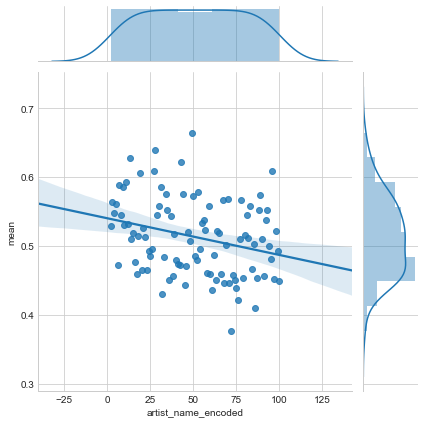

In [103]:
artist_regression = stats_artist.groupby('artist_name_encoded').target.agg(['mean', 'count']).reset_index()[1:100]
g = sns.jointplot("artist_name_encoded", "mean", data=artist_regression, kind='reg')

- Populariy介於`0 ~ 1`之間, 大多集中在0.48左右, 點擊數越低的歌手popularity趨勢也稍微下滑(越往右邊點擊數`count`越低), 簡單講就是和Popularity呈正向關係

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

- 再來細看一下, 這裡我們觀察被點擊率前30名歌手的熱點圖, 並去除第一名的 `Various artists`
- 再區分年齡來觀察

In [37]:
age_tick = ['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80']

candidate_artist = artist_vc[1:30].index.values
chop = stats_artist # .query("msno_age_catg != ''")
chop = chop[chop.artist_name.isin(candidate_artist)]

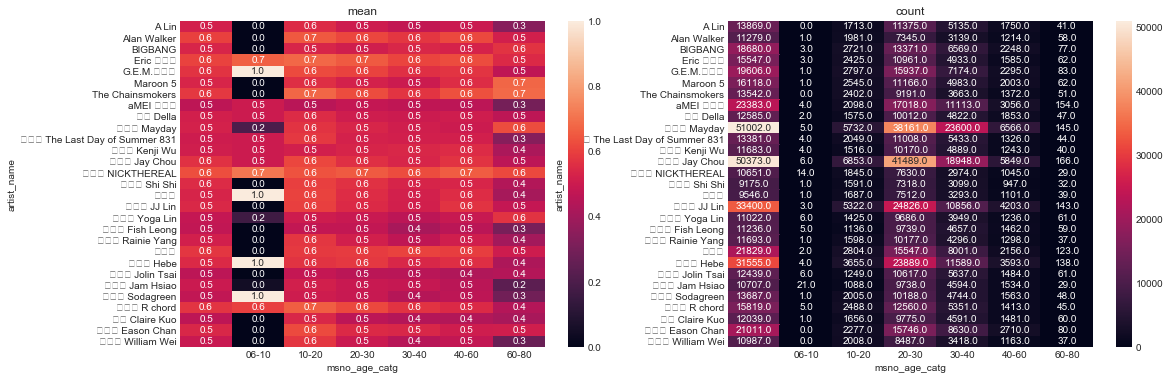

Gender: 


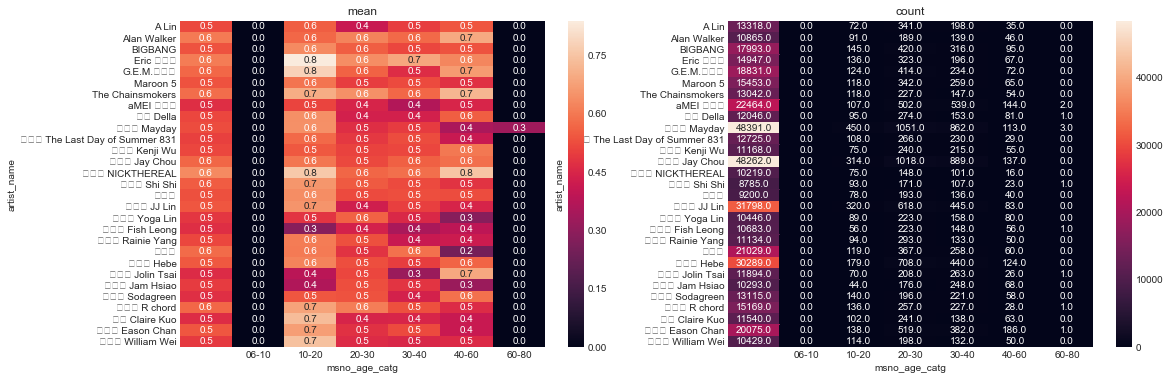

Gender: male


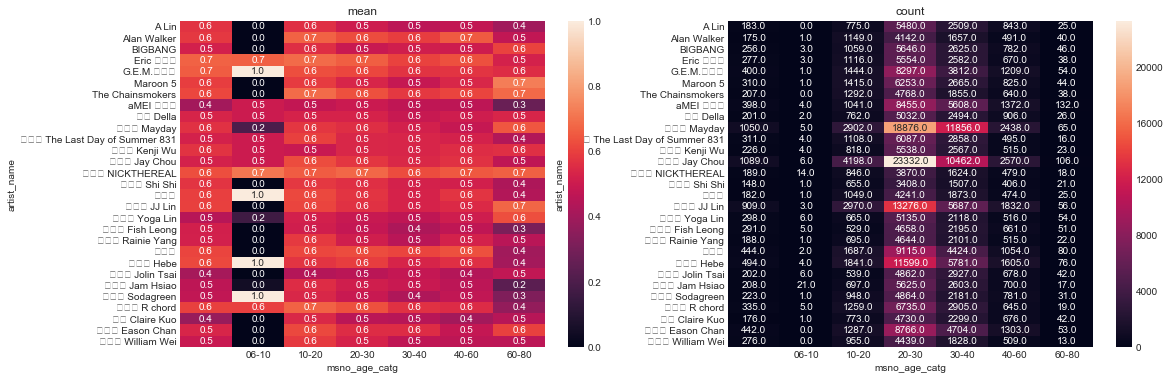

Gender: female


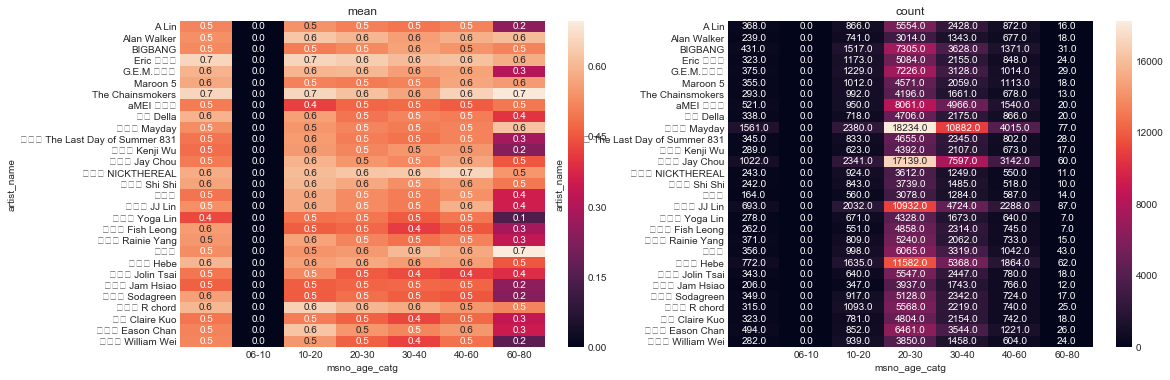

In [39]:
utils_nb.heatmap(chop, 'artist_name', 'msno_age_catg', annot=True, xtick=age_tick, fmt='.1f', figsize=(18, 6))

for gd in ('', 'male', 'female'):
    print(f'Gender: {gd}')
    utils_nb.heatmap(chop.query(f"gender == '{gd}'"), 
                     'artist_name', 'msno_age_catg', annot=True, 
                     xtick=age_tick, fmt='.1f', figsize=(18, 6))

- 上述來看, 五月天(Mayday)與周杰倫(Jay Chou)是點擊冠軍, 其次是林俊傑(J.J Lin)與Hebe等等
- 扣除數量少的族群只看10 ~ 60歲之間, 即使分性別來看, 平均喜好程度都在0.5 ~ 0.6, 沒有顯著資訊
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## 以作曲家(Composer)為主
- `utils.CountMapper`依照點擊數量將歌手排名, 並mapping到1開始的數字, 也就是說index越小的出現頻率越高

In [40]:
stats_composer = utils_nb.flatten(data, ['gender', 'msno_age_catg', 'city', 'language', 'song_pplrty'], 'composer', 'target')
composer_mapper = utils.CountMapper(outlier='')
stats_composer['composer_encoded'] = composer_mapper.fit_transform(stats_composer.composer)
stats_composer.head()

,gender,msno_age_catg,city,language,song_pplrty,composer,target,composer_encoded
0,,,1,52,0.000,Benjamin Gibbard,0,10920
1,,,1,52,0.235,Jerrod Bettis,0,8477
2,,,1,52,0.235,Ryan Tedder,0,39
3,,,1,52,0.235,Tim Myers,0,2618
4,,,1,52,0.235,Zachary Filkins,0,2528


In [97]:
composer_vc = stats_composer.composer.value_counts()
print(composer_vc[:10], '\n')
print( composer_vc.describe() )

                  1070790
周杰倫                134566
阿信                  62339
林俊傑                 54838
陳皓宇                 42238
Max Martin          37368
JJ Lin              33050
TEDDY               32473
Andrew Taggart      31147
張簡君偉                30564
Name: composer, dtype: int64 

count     69096.000
mean        107.304
std        4182.736
min           1.000
25%           1.000
50%           3.000
75%          15.000
max     1070790.000
Name: composer, dtype: float64


h:\anaconda3\envs\py3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


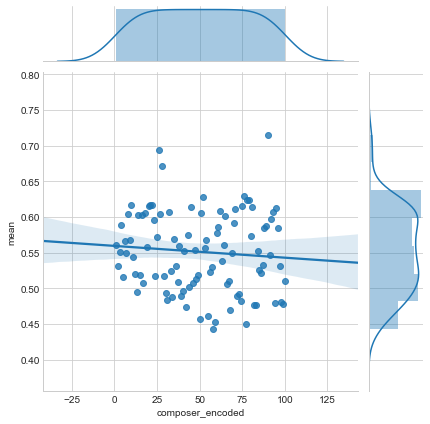

In [98]:
composer_regression = stats_composer.groupby('composer_encoded').target.agg(['mean', 'count']).reset_index()[1:101]
g = sns.jointplot("composer_encoded", "mean", data=composer_regression, kind='reg')

- `artist_name`, `composer` 資料分布都是long tail形式, composer更為嚴重, 而且空值(missing value)佔據數量第一, 所以畫regression圖示的時候排除空值
- 與`artist_name一樣`, `composer`點擊數越低的作曲家, popularity趨勢也稍微下滑(越往右邊點擊數count越低), 但趨勢較為緩和

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

我們排除空值取前30名composer觀看熱點圖

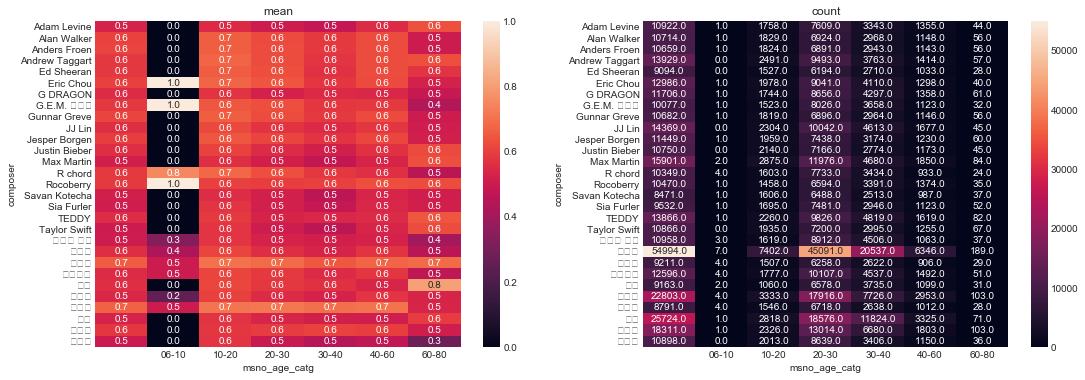

msno_age_catg,,06-10,10-20,20-30,30-40,40-60,60-80
composer,,,,,,,
Adam Levine,10922.000,1.000,1758.000,7609.000,3343.000,1355.000,44.000
Alan Walker,10714.000,1.000,1829.000,6924.000,2968.000,1148.000,56.000
Anders Froen,10659.000,1.000,1824.000,6891.000,2943.000,1143.000,56.000
Andrew Taggart,13929.000,nan,2491.000,9493.000,3763.000,1414.000,57.000
Ed Sheeran,9094.000,nan,1527.000,6194.000,2710.000,1033.000,28.000
Eric Chou,12986.000,1.000,1978.000,9041.000,4110.000,1298.000,40.000
G DRAGON,11706.000,1.000,1744.000,8656.000,4297.000,1358.000,61.000
G.E.M. 鄧紫棋,10077.000,1.000,1523.000,8026.000,3658.000,1123.000,32.000
Gunnar Greve,10682.000,1.000,1819.000,6896.000,2964.000,1146.000,56.000


In [45]:
age_tick = ['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80']

chop = stats_composer # .query("msno_age_catg != '' and composer != ''")
candicate_composer = composer_vc[1:30].index.values
chop = chop[chop.composer.isin(candicate_composer)]
utils_nb.heatmap(chop, 'composer', 'msno_age_catg', annot=True, xtick=age_tick, fmt='.1f', figsize=(18, 6))

chop.groupby(['composer', 'msno_age_catg']).target.size().reset_index().pivot('composer', 'msno_age_catg', 'target')

- 因為不想花時間解決亂碼問題, 所以下方列出了熱點圖的對照table, Composer = `周杰倫`的歌曲點擊數是最高的, 橫跨10 ~ 60歲, 再來則是阿信(五月天 Mayday), 與`artist_name`一樣 ==> 歌手與作曲同一人的有才歌手特別受歡迎
- heatmap mean的部分則沒有顯著的information
- 作曲數雖不多, `周湯豪`和`薛之謙`作曲普遍喜好率都有在0.7

<br/>
<br/>
<br/>

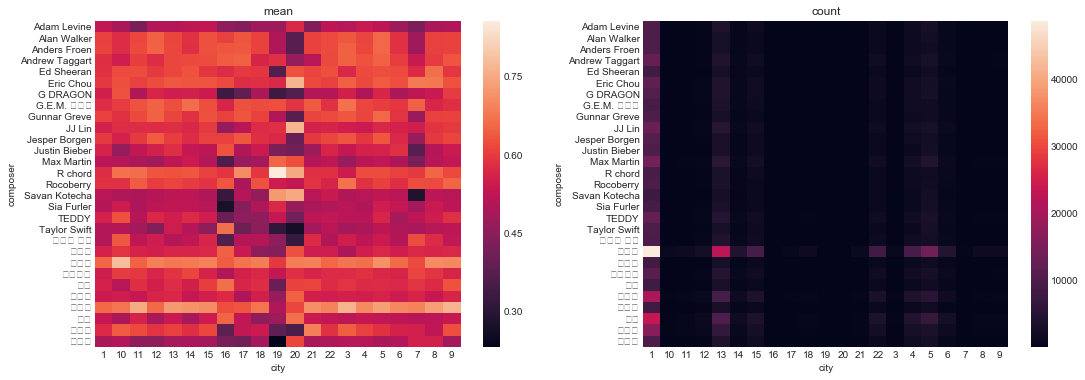

city,1,10,11,12,13,14,15,16,17,18,...,20,21,22,3,4,5,6,7,8,9
composer,,,,,,,,,,,,,,,,,,,,,
Adam Levine,9917,206,245,411,3745,698,1686,35,159,225,...,7,209,1358,189,1543,2894,865,94,230,295
Alan Walker,10043,204,256,429,3152,647,1429,23,142,227,...,16,236,1302,200,1616,2285,815,71,284,257
Anders Froen,9992,204,254,428,3135,646,1422,22,141,227,...,16,236,1295,193,1599,2275,814,71,284,257
Andrew Taggart,12915,260,363,553,4295,849,1875,28,199,304,...,30,244,1786,279,2049,3184,1072,87,371,392
Ed Sheeran,8332,182,237,375,2859,598,1265,26,117,209,...,19,142,1150,165,1438,2242,676,66,228,249
Eric Chou,11849,323,303,589,4345,904,1869,29,181,304,...,30,252,1662,252,1982,2711,1012,123,359,361
G DRAGON,10444,290,287,611,4250,897,1880,24,163,341,...,11,247,1585,209,1910,2864,951,154,322,377
G.E.M. 鄧紫棋,9130,261,295,545,3721,804,1709,30,148,260,...,34,236,1464,221,1761,2253,893,83,289,295
Gunnar Greve,10011,201,255,427,3144,645,1426,23,142,226,...,16,235,1298,200,1611,2278,812,70,281,257


In [106]:
chop = stats_composer # .query("msno_age_catg != '' and composer != ''")
candicate_composer = composer_vc[1:30].index.values
chop = chop[chop.composer.isin(candicate_composer)]
utils_nb.heatmap(chop, 'composer', 'city', annot=False, fmt='.1f', figsize=(18, 6))

chop.groupby(['composer', 'city']).target.size().reset_index().pivot('composer', 'city', 'target')

- `composer` x `city` x `target` 並無其他顯著資訊

<br/>
<br/>
<br/>

## Data Exploratory Conclusion
- 歌曲本身的受歡迎程度(`song_pplrty`, `song_clicks`)會增加一個user可能喜歡的機會
- KKBOX使用者年齡分布極度傾斜在20 ~ 30歲的使用者
- 歌曲的語言`language`, 年分`song_yy`是顯著的feature(即使不直接與target線性相關), 且新歌受歡迎程度普遍高於舊歌
---

因為是個人化推薦系統的資料, 普遍性的EDA(Exploratory Data Analisys), 無法擷取到太多資訊, 針對個人我們仍然會統計歷史紀錄, 計算人和歌曲之間的互動關係, 個人針對歌曲各項feature皆會和target欄位計算`mean`, `count`統計量, 若是類別變數則善用`Embedding`去做向量平均的動作, 在高維空間能夠呈現個人喜好的向量

## Module structure
    ```
    └─trainer
        │  app_conf.py
        │  ctrl.py
        │  input.py
        │  logging.yaml
        │  metadata.py
        │  model.py
        │  service.py
        └─utils
           │  flex.py
           │  utils.py
           └─ utils_nb.py
    ```
    Directory trainer contains all modules: 
    
|File Name| Purpose
|:---|:---
|[app_conf.py](trainer/app_conf.py) | Applicaiton configures, tell where are the training data, the model checkpoint directory, and hyperparameter suggested to put app_conf.py instead of pass on the fly to controller.
|[ctrl.py](trainer/ctrl.py) |The entrance of the program, accept any parameters, protable for local terminal or restful style environment. 
|[service.py](trainer/service.py) |The business logic module behind the controller(ctrl.py) 
|[utils.py](trainer/utils/utils.py) | Utility module, some common function to put here, like logging function. 
|[utils_nb.py](trainer/utils/utils_nb.py) | Utility module, especially about functions run on notebook
|[flex.py](trainer/utils/flex.py) | IO module, portable for local io or gcs io
|[metadata.py](trainer/metadata.py)|Defines: 1) task type, 2) input data header, 3) numeric and categorical feature names, 4) target feature name (and labels, for a classification task), and 5) unused feature names. 
|[input.py](trainer/input.py)| Includes: 1) data input functions to read data from csv and tfrecords files, 2) parsing functions to convert csv and tf.example to tensors, 3) function to implement your features custom  processing and creation functionality, and 4) prediction functions (for serving the model) that accepts CSV, JSON, and tf.example instances. 
|[model.py](trainer/model.py)|Includes: 1) function to create DNNRegressor, 2) function to implement for a custom estimator model_fn. 3) include **Feature class** to assign the feature spec, the feature spec usually bind for specific model, so we put them together. 

<br/>
<br/>
<br/>

## Data preprocessing
1. Data offered like this
    ```
    │  members.csv
    │  songs.csv
    │  song_extra_info.csv
    │  test.csv
    └─ train.csv 
    ```
    
2. Data pipeline on training period we propose 4 steps: **Clean -> Prepare -> Fit -> Transform(Split)**
    - Clean: 
        - Fill missing value, drop unnecessary features
        - Rename features
        
    - Split:
        - 這裡我們根據每個user的使用紀錄取前90%進trainin data, 最後10%到valid data, 我們原本是要把Split這一步放到Transform之後, 但是那樣有點作弊行為, 實際上在Serving期間我們是無法看到未來的資料的(prepare fit transform階段都會參考valid data), 當然有些人認為validation data只是用來判斷是否overfitting, 不需要完全禁止使用valid data的資訊, 我們並不否定這個論點, 只是我們想更真實得模擬Serving時的情況, 當然, 少看一部分的data, 在test data的表現上絕對會差一點
        - 我們算每個user的使用量, 並且計算25% ~ 75%的quantile, 歷史log少於25%的user我們不納入training data, 大於75%的user, 假設75% quantile的數字是300, 我們取這個user最近前"300"的紀錄, 目的在於不想被大量使用者或是太少量的使用者去主導整個model的function
        
    - Prepare: 
        - Join store and store_states to make the **Fat table**
        - Add features we mentioned in data exploration, drop also.
        - Filter some records not appropriate, like open = 0
        - Maybe persistent some files

    - Fit: 
        - Persistent the statistical information of numeric features
        - Persistent the unique count value of categorical features
        
    - Transform:
        - Normalization
        - Make all categorical variable to int, one hot encoding ... etc.
        - Because of the scale of sales is large and large standard deviation, **we take logarithm of the target column**
        
    data
        
    ---
    一個Data preprocess的範例
    ```python
    data = self.input.clean(p.fpath, is_serving=False)
    data = self.input.prepare(data, is_serving=False)
    data = self.input.fit(data).transform(data, is_serving=False)
    self.input.split(data)
    ``` 
    
3. 特殊處理:
   - 我們會groupby user去記錄他的歷史聽歌紀錄, 對於類別變數我們之前提到過我們會使用embedding average的功能, e.g:假設有user聽歌紀錄是這樣(只列出前5筆) 
    ![](./kkbox_sample.jpg)
    接著我們就會這樣紀錄此user的資料:
    ```
    msno_artist_name_hist:  ('Alesso', 'Eric 周興哲', 'G.E.M.鄧紫棋', 'Jessica', 'Justin Bieber')
    msno_artist_name_count:  (1, 1, 1, 1, 1)
    msno_artist_name_mean:  (1, 0.5, 0.32, 1, 1)
    ```
    `msno_artist_name_hist`是array, 最後會轉換成integer, 進入tensorflow做embedding, `msno_artist_name_count`, `msno_artist_name_mean`則是weight欄位, 會丟進tensorflow和embedding的`msno_artist_name_hist`做weighted sum的動作, 這樣就能算出此user在`artist_name`上的vector representation, 
    
4. 我們會把算好的統計量寫回profile table, e.g: members, songs, 未來serving時期資料進來的資料, 使用`msno`, `song_id`欄位就能夠使用DataFrame.merge join起來, 就可丟入model做prediction

## Prepare Data: Clean, Prepare, Fit, Transform

`Ctrl.instance.prepare`已經包含了 clean, split, prepare, fit transform 4個steps

In [123]:
%%time

params = pd.Series({
    'fpath': './data/train.csv'
})
Ctrl.instance.prepare(params)

2018-08-15 14:42:03,050 - trainer.input - INFO [line:30] - Clean start, is_serving: False
2018-08-15 14:42:32,351 - trainer.input - INFO [line:48] - Clean table members.
2018-08-15 14:42:32,853 - trainer.input - INFO [line:59] - Clean table songs.
2018-08-15 14:43:37,468 - trainer.input - INFO [line:78] - Clean take time 0:01:34.414935
2018-08-15 14:43:38,826 - trainer.input - INFO [line:82] - Split start
2018-08-15 14:43:40,543 - trainer.input - INFO [line:102] - Msno data distribution 
count   30755.000
mean      239.877
std       314.131
min         1.000
25%        27.000
50%       128.000
75%       340.000
max      5819.000
dtype: float64

2018-08-15 14:43:40,545 - trainer.input - INFO [line:103] - Filter training data
2018-08-15 14:44:09,427 - trainer.input - INFO [line:111] - Split take time 0:00:30.598649
2018-08-15 14:44:10,119 - trainer.input - INFO [line:172] - Prepare start
2018-08-15 14:44:16,273 - trainer.input - INFO [line:186] - 
Do prepare_members
2018-08-15 14:44:21,9

d:\python\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-08-15 14:55:24,802 - trainer.input - INFO [line:342] - fit song_length ...
2018-08-15 14:55:25,668 - trainer.input - INFO [line:342] - fit song_pplrty ...
2018-08-15 14:55:26,687 - trainer.input - INFO [line:342] - fit song_clicks ...
2018-08-15 14:55:28,550 - trainer.input - INFO [line:353] - Fit take time 0:02:03.341788
2018-08-15 14:55:34,820 - trainer.input - INFO [line:363] - Transform start
2018-08-15 14:55:48,600 - trainer.input - INFO [line:397] - transform city, vocab_key: city ...
2018-08-15 14:55:48,607 - trainer.input - INFO [line:525] - transform take time 0:00:00.004986
2018-08-15 14:55:48,626 - trainer.input - INFO [line:397] - transform gender, vocab_key: gender ...
2018-08-15 14:55:48,633 - trainer.input - INFO [line:525] - transform take time 0:00:00.005985
2018-08-15 14:55:48,651 - trainer.input - INFO [line:397] - transform registered_via, vocab_key: registered_via ...
2018-08-15 14:55:48,657 - trainer.input - INFO [line:525] - transform take time 0:00:00.00498

d:\python\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-08-15 14:55:51,284 - trainer.input - INFO [line:525] - transform take time 0:00:02.538900
2018-08-15 14:55:51,488 - trainer.input - INFO [line:408] - transform msno_neg_query_hist, vocab_key: song_id ...
2018-08-15 14:55:53,676 - trainer.input - INFO [line:525] - transform take time 0:00:02.187680
2018-08-15 14:55:53,802 - trainer.input - INFO [line:408] - transform msno_artist_name_hist, vocab_key: artist_name ...
2018-08-15 14:55:54,654 - trainer.input - INFO [line:525] - transform take time 0:00:00.851855
2018-08-15 14:55:54,676 - trainer.input - INFO [line:408] - transform msno_composer_hist, vocab_key: composer ...
2018-08-15 14:55:56,451 - trainer.input - INFO [line:525] - transform take time 0:00:01.774145
2018-08-15 14:55:56,498 - trainer.input - INFO [line:408] - transform msno_genre_ids_hist, vocab_key: genre_ids ...
2018-08-15 14:55:56,699 - trainer.input - INFO [line:525] - transform take time 0:00:00.200042
2018-08-15 14:55:56,705 - trainer.input - INFO [line:408] - t

## Model Structure

![model structure](./kkbox_model_structure.jpg)

之前介紹過我們使用的除了一般的DNN架構(fully connected layer), 也嘗試加入Matrix Factorization的架構, DNN Part在圖右, 是我們第一個model(dnn), 第二個是DNN + MF model(neu_mf), 而和論文不同的是, 我們多了`context feature`, 像是`source_system_tab`, `source_screen_name`, `source_type`, 一樣是以concate納入input layer.

- 一般設定:
    - Loss function: sigmoid cross entropy
    - Optimizer: `tf.train.AdamOptimizer`, 
    - Learning rate: 初始為0.001, 搭配`tf.train.cosine_decay`使用
    - Overfitting check: check the train section, we use best checkpoint(`trainer.model.BestScoreExporter`) to avoid overfitting.
    - SeLU activation function at each layer(Self Normalization)
    - DNN Structure: `input dim -> 512 -> 128 -> 64`
        - 我們對參數使用[max norm constrain](http://cs231n.github.io/neural-networks-2/#reg), 這是其中一種regularization的方式
        ```python
        tf.layers.dense(factor, layer, kernel_initializer=uniform_init_fn,
                        kernel_constraint=tf.keras.constraints.max_norm(),
                        ...
        ```

- DNN Model:
    - 架構和一般設定DNN Structure相同, concat [member feature, song feature, context feature] -> 512 -> 128 -> 64
    
- NEU_MF Model:
    - 多了`MF Part`, 我們必須將members和songs經過fully connected layer encode 到相同長度才有辦法相乘, 這裡的設定是 
        - [member feature] -> 32 -> 16
        - [song feature] -> 32 -> 16
        
      兩個vector element wise相乘 => 再跟DNN part vector做串接


- 在Data Preprocess的區塊我們提到我們會大量的去算每個user的統計量以及每首歌的統計量, 像是song popularity.., 在user部分我們並不使用user id embedding, 我們以他過去的聽歌紀錄來代表這個人, 對應到`target = 1`的部分放入`msno_pos_query_hist`欄位, `target = 0`放入`msno_neg_query_hist`, 紀錄該user正向紀錄與負向紀錄, 另一個好處是, 日後未知的user有沒看過的user id, 我們只要有他的聽歌紀錄(song_id), 就可以對這位user做prediction, 減少retrain model的需求.
    

<br/>
<br/>


## Training

我們使用`tf.estimator.Estimator`, 最主要的參數就是`model_fn`, 這是callback function, function參數有三個, `features`, `label`, `mode`
- features: 傳入的data, 是以python dictionary儲存
- label: data的label feature
- mode: `tf.estimator.ModeKeys`, 指定TRAIN, EVAL, PREDICT其中一個
`model_fn`則是自己實作graph的部分, 


因為我們使用`tf.estimator.train_and_evaluate`, 除了estimator物件, 他要求train_spec and eval_spec參數
- train_spec and eval_spec: 
  train_spec和eval_spec都要求data function, 這個function可以一直批次的吐出data, 內部有個隱性的迴圈, 這裡我們使用[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) api去擷取資料, 他底層可支援多核心同時運算加快資料IO速度, , 範例如下:
    ```python
        def generate_input_fn(self,
              file_names_pattern, mode, skip_header_lines=False, is_serving=False,
              batch_size=256, num_epochs=1, num_threads=4):
    
            buffer_size = batch_size * 2
            def _input_fn():
                num_threads = multiprocessing.cpu_count() if multi_threading else 1
                file_names = tf.matching_files(file_names_pattern)

                is_serving = True if mode == tf.estimator.ModeKeys.PREDICT else False
                dataset = tf.data.TextLineDataset(filenames=file_names)
                dataset = dataset.skip(skip_header_lines)
                dataset = dataset.map(lambda csv_row: self.parse_csv(csv_row, is_serving=is_serving))
                dataset = dataset.map(lambda features: self.get_features_target_tuple(features), 
                                      num_parallel_calls=num_threads)
                if shuffle:
                    dataset = dataset.shuffle(buffer_size)
                dataset = dataset.batch(batch_size)\
                                 .prefetch(buffer_size)\
                                 .repeat(num_epochs)
                iterator = dataset.make_one_shot_iterator()
                features, target = iterator.get_next()
                return features, target
        return _input_fn
    ```
  其中參數`num_threads`就是指定多少cpu core去平行處理您的資料
  
  <br/>
  
  Train, eval spec的範例如下
    ```python
    # Train spec
    train_fn = generate_input_fn(...)
    train_spec = tf.estimator.TrainSpec(
        train_fn,
        max_steps=train_steps,
    )
    # Valid spec
    valid_fn = generate_input_fn(...)
    eval_spec = tf.estimator.EvalSpec(
        valid_fn,
        steps=valid_steps,
        exporters=[exporter]
    )
    ```
  EvalSpec的參數`exporters`是evaluate的時候選擇如何去export您的model, 這裡並不是model checkpoint files, 而是[protobufs](https://www.tensorflow.org/extend/tool_developers/#protocol_buffers)檔(`.pb`), 我們可以自訂exporter, 透過繼承`tf.estimator.Exporter`撰寫自己export的邏輯, 這裡我們實作`BestScoreExporter`(tensorflow 1.10已經有[BestScoreExporter](https://www.tensorflow.org/api_docs/python/tf/estimator/BestExporter)可以直接呼叫, 當然在我們開發階段沒有), 在eval時期我們比對過去eval的metric, 像是loss, 或是accuracy, 如果這次的eval結果有更好(像是loss更低或是accuracy更高), 就export model, 否則不export
    ```python
    class BestScoreExporter(tf.estimator.Exporter):
        # ...
        def export(self, estimator, export_path, checkpoint_path, eval_result,
             is_the_final_export):

            print(f'eval_result: {eval_result}')
            curloss = eval_result['rmspe']
            if self.best is None or self.best >= curloss:
                estimator.export_savedmodel(
                    export_path,
                    self.serving_input_receiver_fn,
                    assets_extra=self.assets_extra,
                    as_text=self.as_text,
                    checkpoint_path=checkpoint_path)
            else:
                # do nothing
    ```
    在export model的同時我們實作一個很重要的function: `serving_input_receiver_fn`, 這個function必須傳給`tf.estimator.Exporter`, 他是處理serving時期的資料如何轉換成model認識的規格, 並且會回傳`tf.estimator.export.ServingInputReceiver`, 並不是實際去transform資料, 而是規格上的轉換, 有可能接收到的資料規格與丟進tensorflow model的規格是一樣的, 以下是範例:
    ```python
    def json_serving_input_fn(self):
        columns = metadata.SERVING_COLUMNS
        shapes = self.get_shape(is_serving=True)
        dtypes = metadata.SERVING_DTYPES

        inputs = OrderedDict()
        for name, shape, typ in zip(columns, shapes, dtypes):
            # Remember add batch dimension to first position of shape
            inputs[name] = tf.placeholder(shape=[None, None] if len(shape) > 0 else [None], dtype=typ, name=name)

        return tf.estimator.export.ServingInputReceiver(
            features=inputs,
            receiver_tensors=inputs
        )
    ```
    上述透過metadata得知如何宣告placeholder的dtype與shape, online prediction通常會使用json格式, 如果是batch的使用情境, 這裡也可以實作讀取csv的作法, 傳入的參數就可能是一個以上的csv檔名, receiver_tensors可能是dtype=string的placeholder, 而features應該就是model認得的tensor規格
    
    <br/>
    
- 其他設定:
    - Batch size = 256
    - Train steps = 4385 (about 1 epochs)
    - Valid steps = 492 (about 1 epoch)
    - Drop out rate: 0

### DNN Model

In [ ]:
%%time

tf.reset_default_graph()
service.Service.instance.train(model_name='dnn', reset=True)

2018-08-15 15:14:33,713 - trainer.service - INFO [line:29] - Model: dnn, model_dir: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm
2018-08-15 15:14:34,709 - trainer.service - INFO [line:47] - Use model dnn: <trainer.model.Model object at 0x000001B2CA4C8D68>
2018-08-15 15:14:34,710 - trainer.service - INFO [line:48] - Model Directory: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm
2018-08-15 15:14:34,712 - BestScoreExporter - INFO [line:400] - BestScoreExporter init, last best eval is None
2018-08-15 15:14:34,713 - trainer.service - INFO [line:59] - read train file into memory
2018-08-15 15:15:11,504 - trainer.service - INFO [line:78] - read valid file into memory
2018-08-15 15:15:23,151 - trainer.model - INFO [line:283] - creating a custom Estimator
INFO:tensorflow:Using config: {'_model_dir': 'D:\\Python\\notebook\\ml_specialized\\kkbox/models/kkbox_dnn_adam_max_norm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoin

2018-08-15 15:32:50,304 - tensorflow - INFO [line:115] - Loss for final step: 0.51668096.
2018-08-15 15:32:50,357 - trainer.input - INFO [line:668] - 
2018-08-15 15:32:50,358 - trainer.input - INFO [line:669] - * data input_fn:
2018-08-15 15:32:50,359 - trainer.input - INFO [line:670] - ================
2018-08-15 15:32:50,360 - trainer.input - INFO [line:671] - Mode: eval
2018-08-15 15:32:50,361 - trainer.input - INFO [line:672] - Batch size: 1000
2018-08-15 15:32:50,361 - trainer.input - INFO [line:673] - Epoch count: 1
2018-08-15 15:32:50,361 - trainer.input - INFO [line:674] - Thread count: 8
2018-08-15 15:32:50,362 - trainer.input - INFO [line:675] - Shuffle: False
2018-08-15 15:32:50,362 - trainer.input - INFO [line:676] - ================
2018-08-15 15:32:50,363 - trainer.input - INFO [line:677] - 
INFO:tensorflow:Calling model_fn.
2018-08-15 15:32:50,554 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-15 15:32:50,557 - trainer.model - INFO [line:156] - mode: eval, is

2018-08-15 15:41:55,161 - trainer.input - INFO [line:673] - Epoch count: 1
2018-08-15 15:41:55,161 - trainer.input - INFO [line:674] - Thread count: 8
2018-08-15 15:41:55,161 - trainer.input - INFO [line:675] - Shuffle: True
2018-08-15 15:41:55,161 - trainer.input - INFO [line:676] - ================
2018-08-15 15:41:55,161 - trainer.input - INFO [line:677] - 
2018-08-15 15:41:55,161 - trainer.input - INFO [line:681] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-08-15 15:42:29,625 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-15 15:42:29,630 - trainer.model - INFO [line:156] - mode: train, is_train: True, use dropout: False
2018-08-15 15:42:29,951 - trainer.model - INFO [line:82] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-08-15 15:42:30,174 - trainer.model - INFO [line:124] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-08-15 15:42:30,185 - trainer.model - INFO

INFO:tensorflow:Evaluation [490/492]
2018-08-15 16:08:55,099 - tensorflow - INFO [line:115] - Evaluation [490/492]
INFO:tensorflow:Evaluation [492/492]
2018-08-15 16:08:57,884 - tensorflow - INFO [line:115] - Evaluation [492/492]
INFO:tensorflow:Finished evaluation at 2018-08-15-08:08:57
2018-08-15 16:08:57,978 - tensorflow - INFO [line:115] - Finished evaluation at 2018-08-15-08:08:57
INFO:tensorflow:Saving dict for global step 1225: auc = 0.70645946, global_step = 1225, loss = 0.6878882
2018-08-15 16:08:57,980 - tensorflow - INFO [line:115] - Saving dict for global step 1225: auc = 0.70645946, global_step = 1225, loss = 0.6878882
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1225: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-1225
2018-08-15 16:08:57,989 - tensorflow - INFO [line:115] - Saving 'checkpoint_path' summary for global step 1225: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-1225
201

INFO:tensorflow:loss = 0.49981314, step = 1625 (123.937 sec)
2018-08-15 16:18:24,647 - tensorflow - INFO [line:115] - loss = 0.49981314, step = 1625 (123.937 sec)
INFO:tensorflow:Saving checkpoints for 1725 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
2018-08-15 16:20:28,392 - tensorflow - INFO [line:115] - Saving checkpoints for 1725 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
INFO:tensorflow:global_step/sec: 0.714873
2018-08-15 16:20:44,524 - tensorflow - INFO [line:115] - global_step/sec: 0.714873
INFO:tensorflow:loss = 0.481703, step = 1725 (139.887 sec)
2018-08-15 16:20:44,534 - tensorflow - INFO [line:115] - loss = 0.481703, step = 1725 (139.887 sec)
INFO:tensorflow:global_step/sec: 0.845601
2018-08-15 16:22:42,775 - tensorflow - INFO [line:115] - global_step/sec: 0.845601
INFO:tensorflow:loss = 0.49771902, step = 1825 (118.254 sec)
2018-08-15 16:22:42,788 - tensorflow - INFO [line:115] - loss 

INFO:tensorflow:Signatures INCLUDED in export for Train: None
2018-08-15 16:35:43,854 - tensorflow - INFO [line:115] - Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
2018-08-15 16:35:43,856 - tensorflow - INFO [line:115] - Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2005
2018-08-15 16:35:43,920 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2005
INFO:tensorflow:Assets added to graph.
2018-08-15 16:35:44,002 - tensorflow - INFO [line:115] - Assets added to graph.
INFO:tensorflow:No assets to write.
2018-08-15 16:35:44,003 - tensorflow - INFO [line:115] - No assets to write.
INFO:tensorflow:SavedModel written to: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\export\estimator\temp-b'1534322

2018-08-15 16:53:20,180 - trainer.model - INFO [line:166] - net: Tensor("dnn/concat:0", shape=(?, 48), dtype=float32)
INFO:tensorflow:Done calling model_fn.
2018-08-15 16:53:20,349 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-15-08:53:20
2018-08-15 16:53:20,369 - tensorflow - INFO [line:115] - Starting evaluation at 2018-08-15-08:53:20
INFO:tensorflow:Graph was finalized.
2018-08-15 16:53:20,565 - tensorflow - INFO [line:115] - Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2784
2018-08-15 16:53:20,635 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2784
INFO:tensorflow:Running local_init_op.
2018-08-15 16:53:21,010 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-15 16:53:21,025 - t

INFO:tensorflow:global_step/sec: 0.795118
2018-08-15 17:18:30,982 - tensorflow - INFO [line:115] - global_step/sec: 0.795118
INFO:tensorflow:loss = 0.49097255, step = 3484 (125.770 sec)
2018-08-15 17:18:31,003 - tensorflow - INFO [line:115] - loss = 0.49097255, step = 3484 (125.770 sec)
INFO:tensorflow:Saving checkpoints for 3558 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
2018-08-15 17:20:03,157 - tensorflow - INFO [line:115] - Saving checkpoints for 3558 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
INFO:tensorflow:Loss for final step: 0.49348712.
2018-08-15 17:20:09,535 - tensorflow - INFO [line:115] - Loss for final step: 0.49348712.
2018-08-15 17:20:09,574 - trainer.input - INFO [line:668] - 
2018-08-15 17:20:09,576 - trainer.input - INFO [line:669] - * data input_fn:
2018-08-15 17:20:09,576 - trainer.input - INFO [line:670] - ================
2018-08-15 17:20:09,577 - trainer.input - INFO [line:

INFO:tensorflow:loss = 0.4522073, step = 3558
2018-08-15 17:30:25,782 - tensorflow - INFO [line:115] - loss = 0.4522073, step = 3558
INFO:tensorflow:global_step/sec: 0.795041
2018-08-15 17:32:31,529 - tensorflow - INFO [line:115] - global_step/sec: 0.795041
INFO:tensorflow:loss = 0.45521742, step = 3658 (125.812 sec)
2018-08-15 17:32:31,590 - tensorflow - INFO [line:115] - loss = 0.45521742, step = 3658 (125.812 sec)
INFO:tensorflow:global_step/sec: 0.785355
2018-08-15 17:34:38,871 - tensorflow - INFO [line:115] - global_step/sec: 0.785355
INFO:tensorflow:loss = 0.4466053, step = 3758 (127.303 sec)
2018-08-15 17:34:38,893 - tensorflow - INFO [line:115] - loss = 0.4466053, step = 3758 (127.303 sec)
INFO:tensorflow:global_step/sec: 0.84733
2018-08-15 17:36:36,880 - tensorflow - INFO [line:115] - global_step/sec: 0.84733
INFO:tensorflow:loss = 0.4582394, step = 3858 (117.997 sec)
2018-08-15 17:36:36,890 - tensorflow - INFO [line:115] - loss = 0.4582394, step = 3858 (117.997 sec)
INFO:tens

2018-08-15 17:55:49,714 - trainer.input - INFO [line:677] - 
2018-08-15 17:55:49,715 - trainer.input - INFO [line:681] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-08-15 17:56:23,495 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-15 17:56:23,502 - trainer.model - INFO [line:156] - mode: train, is_train: True, use dropout: False
2018-08-15 17:56:23,814 - trainer.model - INFO [line:82] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-08-15 17:56:23,995 - trainer.model - INFO [line:124] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-08-15 17:56:24,011 - trainer.model - INFO [line:133] - self.context_features: Tensor("context/context_features:0", shape=(?, 9), dtype=float32)
2018-08-15 17:56:24,101 - trainer.model - INFO [line:166] - net: Tensor("dnn/concat:0", shape=(?, 48), dtype=float32)
INFO:tensorflow:Done calling model_fn.
2018-08-15 17:56:31,224 - tensorflow - INF

### Neural(DNN) + MF Model

In [ ]:
%%time
p = app_conf.instance
tf.reset_default_graph()
service.Service.instance.train(model_name='neu_mf', reset=False)

## Model Comparison
![](./kkbox_auc.jpg)
從圖可知, Kaggle評分標準是以AUC(under ROC curve), 所以直接看AUC分數, 兩個model其實差不多, 在50萬valid data之下AUC差距不到 0.01, 都在0.77左右, 

<br/>
<br/>

![](./kkbox_loss.jpg)
Loss的部分是使用sigmoid cross entropy, 看來兩個model表現是差不多的, validation的loss到最後似乎有點overfitting, 但是我們使用`BestExporter`, 並不會把叫糟糕的結果給export出去, 不過值得探討的是, loss增加時, auc卻沒有跟著下降, 這裡我們是以最低loss判斷是否要export model, 也許可您可以考慮用最高auc為指標來export model.

## Protocol buffer file inspection
Train完model之後我們使用`saved_model_cli`工具去檢視Protocol Buffers檔案, 目的是去知道如何使用這個model, 當然自己train的model會知道, 但這個工具可以幫助你使用別人train好的model, 詳細請參考[CLI to inspect SavedModel](https://www.tensorflow.org/guide/saved_model)

In [48]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

The given SavedModel contains the following tag-sets:
serve



In [49]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "outputs"
SignatureDef key: "serving_default"



In [50]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def outputs'
print( utils.cmd(command) )

The given SavedModel SignatureDef contains the following input(s):
  inputs['artist_name'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: artist_name:0
  inputs['city'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: city:0
  inputs['composer'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: composer:0
  inputs['expiration_date'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: expiration_date:0
  inputs['gender'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: gender:0
  inputs['genre_ids'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: genre_ids:0
  inputs['language'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: language:0
  inputs['lyricist'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: lyricist:0
  inputs['msno_age_catg'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: msno_age_catg:0
  inputs['msno_age_num']

### Observation
從上面我們可以從一個export的.pb檔清楚地得知資料的input placeholder的資料型態以及shape, 也可知道最後輸出的節點`concatenate/Sigmoid:0`

<br/>
<br/>
<br/>

## Serving
系統接受的Raw data之後要經過轉換才能丟進Model裡面預測, 基本動作跟Training時一樣, 少了Fit的Phase
- Clean: 處理Missing value, drop不需要的欄位
- Prepare: 增加跟Training時一樣的欄位(Feature Engineering時增加的), 資料Merge
- Transform: 轉換Column value, 連續變數的Normalize, 類別變數的one hot encoding


In [6]:
%%time
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))

2018-08-14 17:26:02,697 - trainer.input - INFO [line:30] - Clean start, is_serving: True
2018-08-14 17:26:09,261 - trainer.input - INFO [line:78] - Clean take time 0:00:06.561783
2018-08-14 17:26:09,263 - trainer.input - INFO [line:172] - Prepare start
2018-08-14 17:26:09,264 - trainer.input - INFO [line:198] - Prepare take time 0:00:00
2018-08-14 17:26:09,264 - trainer.input - INFO [line:363] - Transform start
2018-08-14 17:26:41,072 - trainer.input - INFO [line:378] - transform song_id, vocab_key: song_id ...
2018-08-14 17:26:42,729 - trainer.input - INFO [line:525] - transform take time 0:00:01.641232
2018-08-14 17:26:42,804 - trainer.input - INFO [line:378] - transform source_system_tab, vocab_key: source_system_tab ...
2018-08-14 17:26:43,024 - trainer.input - INFO [line:525] - transform take time 0:00:00.219406
2018-08-14 17:26:43,062 - trainer.input - INFO [line:378] - transform source_screen_name, vocab_key: source_screen_name ...
2018-08-14 17:26:43,306 - trainer.input - INFO 

In [7]:
test_df.head()

,city,gender,registered_via,registration_init_time,expiration_date,msno_age_catg,msno_age_num,msno_tenure,msno_pos_query_hist,msno_pos_query_count,...,song_registered_via_count,song_source_screen_name_hist,song_source_screen_name_count,song_source_system_tab_hist,song_source_system_tab_count,song_source_type_hist,song_source_type_count,source_system_tab,source_screen_name,source_type
0,1,0,2,0.579,0.402,0,-0.132,-0.447,"(3299, 5683, 501, 5471, 305, 4151, 45, 8743, 3...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(29, 81, 123, 188)","(0, 3, 6, 7, 11, 12, 1, 10, 17, 2, 9, 4, 5)","(2, 2, 3, 3, 4, 8, 9, 11, 17, 21, 31, 33, 277)","(0, 2, 6, 5, 1, 4, 3)","(1, 2, 6, 18, 32, 52, 310)","(0, 4, 9, 1, 3, 2, 6, 7, 8, 5)","(1, 2, 5, 13, 19, 24, 29, 32, 97, 199)",1,1,1
1,1,0,2,0.579,0.402,0,-0.132,-0.447,"(3299, 5683, 501, 5471, 305, 4151, 45, 8743, 3...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(7, 494, 643, 1333, 1360)","(0, 3, 6, 8, 7, 11, 12, 1, 10, 17, 2, 9, 4, 5,...","(4, 5, 8, 10, 37, 46, 52, 55, 70, 79, 188, 247...","(0, 2, 6, 5, 1, 7, 4, 3, 8)","(2, 2, 16, 53, 78, 87, 206, 1385, 2008)","(0, 4, 11, 9, 1, 3, 12, 2, 6, 7, 8, 5, 10)","(1, 4, 7, 17, 21, 47, 49, 81, 111, 282, 562, 1...",1,1,1
2,1,0,4,0.833,-0.722,0,-0.132,-0.942,"(197, 34, 67, 66, 206, 1665, 2, 1628, 97315, 5...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(1, 2)","(6, 1)","(1, 2)","(2, 1)","(1, 2)","(1, 5)","(1, 2)",2,0,8
3,16,1,1,-2.340,-0.130,2,0.376,2.150,"(624, 3977, 4911, 4605, 466, 1406, 1714, 1379,...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(1, 2, 2, 10)","(1, 4)","(3, 12)","(6, 1, 4)","(1, 2, 12)","(1, 3, 6)","(1, 2, 12)",4,4,6
4,16,1,1,-2.340,-0.130,2,0.376,2.150,"(624, 3977, 4911, 4605, 466, 1406, 1714, 1379,...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(1, 1, 1)","(3, 1, 4)","(1, 1, 1)","(1, 4)","(1, 2)","(4, 3, 6)","(1, 1, 1)",4,4,6


## Local prediction
1. Transform raw input data for prediction
    - 我們會呼叫 `Ctrl.instance.transform`去轉換進來的raw data, 他自己會去merge store的資訊, 變成所謂的**Fat Table**之後再餵給model預測
    ```python
    def transform(self, p):
        data = self.input.clean(fpath, is_serving=True)
        data = self.input.prepare(data, is_serving=True)
        data = self.input.transform(data, is_serving=True)
        return data
    ```
    
2. Local prediction
    - call ctrl.local_predict: simply use `tensorflow.contrib.predictor`
        ```python
        from tensorflow.contrib import predictor
        predict_fn = predictor.from_saved_model(export_dir, signature_def_key='predict')
        pred = predict_fn( ... )
        ```     
3. Handle Multivariate feature:
    - multivariate feature(像是`artist_name`), 每筆資料長度不一, 每個需要padding成一樣長度才能送入tensorflow, training時期dataset api處理了這一點, serving時期不透過dataset api則向下列範例code, 使用`tf.keras.preprocessing.sequence.pad_sequences`:
    ```python
    pad = tf.keras.preprocessing.sequence.pad_sequences
    # ...
    for pos in np.arange(len(indices) - 1):
        s = datetime.now()
        start, nxt = indices[pos], indices[pos + 1]
        pipe = data[start:nxt].copy()

        for m_col in multi_cols:
            pipe[m_col] = pad(pipe[m_col], padding='post', dtype=typ).tolist()
    ```

In [62]:
%%time
params = pd.Series({
    'datasource': test_df[:10000],
    'is_src_file': True,
    'model_name': 'neu_mf'
})
pred = Ctrl.instance.local_predict(params)

INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_adam_max_norm/export/estimator/1532950716\variables\variables
2018-08-15 13:02:36,189 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_adam_max_norm/export/estimator/1532950716\variables\variables
2018-08-15 13:02:37,039 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.716429
2018-08-15 13:02:37,500 - trainer.ctrl - INFO [line:110] - 1000/10000 ...
2018-08-15 13:02:38,486 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.984682
2018-08-15 13:02:38,760 - trainer.ctrl - INFO [line:110] - 2000/10000 ...
2018-08-15 13:02:39,320 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.559011
2018-08-15 13:02:39,582 - trainer.ctrl - INFO [line:110] - 3000/10000 ...
2018-08-15 13:02:40,137 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.553813
2018-08

## Notes
從上述Serving Data轉換過後的資料, 我們用了很多Multivariate的欄位(grid裡面是array型態, 不是單一value), 這在處理資料時會花費不少時間和系統資源, 所以預測時間會稍微拉長, 上面只顯示前一萬筆的預測就需要11秒的時間

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Deply to ml-engine
- 因為我們將model deploy到GCP的ML-Engine, 需要有GCP帳號去取得service account key file, 才能夠透過key file用您的AP server去存取GCP的服務, 在`trainer.app_conf.Config.api_key_path`就是指定key file的path, 否則無法與GCP聯繫
- ML-Engine的儲存Model需要開一個model repository, 在repository可以有多個版本, 方便您快速切換serving的model, 這裡我們的做法是讓一個repository底下只有一個版本, 所以deploy model的時候會去刪除repository底下所有model

<br/>
<br/>
<br/>

指定key file到`GOOGLE_APPLICATION_CREDENTIALS`環境變數

In [9]:
%%time
Ctrl.instance.set_client_secret()

2018-08-14 17:27:47,234 - trainer.ctrl - INFO [line:24] - Set env variable [GOOGLE_APPLICATION_CREDENTIALS]
Wall time: 998 µs


將exported的model資料夾上傳到GCS上, 路徑為`gs://ml-specialized/kkbox/models`, 當然GCS的bucket是唯一的, 若您要使用自己的bucket, 名字就無法使用ml-specialized

In [19]:
%%time
p = pd.Series({
    # `bucket_name` and `prefix` tell Where to place the model on cloud ==> gs://{bucket_name}/{prefix}
    'bucket_name': 'ml-specialized',
    'prefix': 'kkbox/models',
    'model_path': service.Service.instance.find_latest_expdir('neu_mf'),
})
Ctrl.instance.upload_model(p)

2018-08-14 13:20:32,234 - trainer.ctrl - INFO [line:68] - delete ml-specialized/kkbox/models/
2018-08-14 13:20:32,345 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_adam_max_norm\export\estimator\1532950716/saved_model.pb to kkbox/models/saved_model.pb
2018-08-14 13:20:32,858 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_adam_max_norm\export\estimator\1532950716\variables/variables.data-00000-of-00001 to kkbox/models/variables/variables.data-00000-of-00001
2018-08-14 13:20:39,389 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_adam_max_norm\export\estimator\1532950716\variables/variables.index to kkbox/models/variables/variables.index
Wall time: 8.81 s


### Deploy
一個使用restful api方式去deploy model的範例
```python
def create_model_ver(self, ml, model_name, deployment_uri):
    model_uri = f'projects/{self.p.project_id}/models/{model_name}'
    now = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
    version = f'v{now}'
    
    res = ml.projects().models().versions().create(
        parent=model_uri,
        body={
            'name': version,
            'description': 'Regression model use tf.estimator.DNNRegressor',
            'deploymentUri': deployment_uri,
            'runtimeVersion': '1.8'
        }
    ).execute()
    return res
```
- 參數ml: 是gcp resource object, 通常以下列方式取得
    ```python
    from googleapiclient import discovery

    credentials = GoogleCredentials.get_application_default()
    ml = discovery.build('ml', 'v1', credentials=credentials)
    ```
- 參數deployment_uri: GCS model放置的路徑

In [20]:
%%time

p = pd.Series({
    'model_name': 'ml_specilized_kkbox',
    'deployment_uri': 'gs://ml-specialized/kkbox/models'
})
Ctrl.instance.deploy(p)

2018-08-14 13:22:05,931 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json
2018-08-14 13:22:05,932 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-14 13:22:05,935 - oauth2client.client - INFO [line:795] - Refreshing access_token
2018-08-14 13:22:09,127 - googleapiclient.discovery - INFO [line:868] - URL being requested: GET https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_kkbox/versions?alt=json
2018-08-14 13:22:09,432 - trainer.service - INFO [line:216] - create model ml_specilized_kkbox from gs://ml-specialized/kkbox/models
2018-08-14 13:22:09,438 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_kkbox/versions?alt=json
Wall time: 6.69 s


### Call deployed model
Because of the traffic volume limitation, just show first 50 rows online prediction

---
Use GCP online prediction with some limitations, model宣告placeholder input都是column base, 但是online prediction卻是要把資料弄成row base的形式上傳
像是這樣
```python
[
    {
        'artist_name': [99, 0],
        'city': 1,
        'composer': [1963, 0, 0, 0, 0],
        'expiration_date': 0.4019061801788267,
        'gender': 0,
        ...
    }
    {...}
    {...}
    ...
]
```

In [9]:
p = pd.Series({
    'model_name': 'ml_specilized_kkbox',
    'datasource': test_df[:50].to_dict('records')
})

Ctrl.instance.set_client_secret()
result = Ctrl.instance.online_predict(p)
result

2018-08-15 11:09:28,902 - trainer.ctrl - INFO [line:24] - Set env variable [GOOGLE_APPLICATION_CREDENTIALS]
2018-08-15 11:09:28,903 - trainer.ctrl - INFO [line:114] - Online prediction ...
2018-08-15 11:09:29,178 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_kkbox:predict?alt=json
2018-08-15 11:09:29,180 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-15 11:09:29,184 - oauth2client.client - INFO [line:795] - Refreshing access_token


[0.3423503637313843,
 0.378696084022522,
 0.6396127939224243,
 0.03554140776395798,
 0.4010670781135559,
 0.09792861342430115,
 0.10591750591993332,
 0.4621749222278595,
 0.09639124572277069,
 0.7124201655387878,
 0.7554605007171631,
 0.14721842110157013,
 0.17979936301708221,
 0.4323860704898834,
 0.19908036291599274,
 0.21389535069465637,
 0.2642297148704529,
 0.491393506526947,
 0.4650004506111145,
 0.7101467251777649,
 0.9608408808708191,
 0.65793377161026,
 0.7310786843299866,
 0.5352250337600708,
 0.21303310990333557,
 0.07515835762023926,
 0.3373296856880188,
 0.08061791211366653,
 0.21357445418834686,
 0.8196007013320923,
 0.16070255637168884,
 0.2620466947555542,
 0.10597825795412064,
 0.2112434208393097,
 0.9269907474517822,
 0.23212245106697083,
 0.35422283411026,
 0.5584720373153687,
 0.4458979070186615,
 0.36533671617507935,
 0.31363949179649353,
 0.46086177229881287,
 0.0905415490269661,
 0.6052122116088867,
 0.003308369778096676,
 0.04359568655490875,
 0.1436191797256469

### Observation 
因為資料欄位有69個, 大多數都是multivariate feature, 就像GCP big query的巢狀與重複欄位, 欄位裡面還有array型態的資料, 丟100筆資料上去onlie prediction就超出單次流量上限(`"Request payload size exceeds the limit: 1572864 bytes."`), 所以上面只顯示50筆的資料預測.

<br/>
<br/>
<br/>

## ROC Graph



In [3]:
vl = pd.read_pickle('./data/processed/transformed/vl.pkl')

In [58]:
%%time

params = pd.Series({
    'datasource': vl.drop('target', 1),
    'is_src_file': True,
    'model_name': 'dnn'
})
pred = Ctrl.instance.local_predict(params)

INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm/export/estimator/1534162051\variables\variables
2018-08-15 12:02:15,039 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm/export/estimator/1534162051\variables\variables
2018-08-15 12:02:15,755 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.597324
2018-08-15 12:02:16,213 - trainer.ctrl - INFO [line:110] - 1000/491940 ...
2018-08-15 12:02:17,228 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:01.013925
2018-08-15 12:02:17,471 - trainer.ctrl - INFO [line:110] - 2000/491940 ...
2018-08-15 12:02:17,994 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.521474
2018-08-15 12:02:18,230 - trainer.ctrl - INFO [line:110] - 3000/491940 ...
2018-08-15 12:02:19,154 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.922419
2018-08-

2018-08-15 12:02:57,081 - trainer.ctrl - INFO [line:110] - 45000/491940 ...
2018-08-15 12:02:57,657 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.575456
2018-08-15 12:02:57,911 - trainer.ctrl - INFO [line:110] - 46000/491940 ...
2018-08-15 12:02:58,698 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.786928
2018-08-15 12:02:58,932 - trainer.ctrl - INFO [line:110] - 47000/491940 ...
2018-08-15 12:02:59,483 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.550235
2018-08-15 12:02:59,760 - trainer.ctrl - INFO [line:110] - 48000/491940 ...
2018-08-15 12:03:00,454 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.692651
2018-08-15 12:03:00,792 - trainer.ctrl - INFO [line:110] - 49000/491940 ...
2018-08-15 12:03:01,872 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:01.078144
2018-08-15 12:03:02,130 - trainer.ctrl - INFO [line:110] - 50000/491940 ...
2018-08-15 12:03:02,660 - trainer.servi

2018-08-15 12:03:40,467 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.754856
2018-08-15 12:03:40,688 - trainer.ctrl - INFO [line:110] - 92000/491940 ...
2018-08-15 12:03:41,222 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.533155
2018-08-15 12:03:41,458 - trainer.ctrl - INFO [line:110] - 93000/491940 ...
2018-08-15 12:03:41,932 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.474002
2018-08-15 12:03:42,148 - trainer.ctrl - INFO [line:110] - 94000/491940 ...
2018-08-15 12:03:43,068 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.919466
2018-08-15 12:03:43,401 - trainer.ctrl - INFO [line:110] - 95000/491940 ...
2018-08-15 12:03:43,979 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.577946
2018-08-15 12:03:44,238 - trainer.ctrl - INFO [line:110] - 96000/491940 ...
2018-08-15 12:03:44,780 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.541368
2018-08-15 12:

2018-08-15 12:04:22,910 - trainer.ctrl - INFO [line:110] - 138000/491940 ...
2018-08-15 12:04:23,469 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.557876
2018-08-15 12:04:23,725 - trainer.ctrl - INFO [line:110] - 139000/491940 ...
2018-08-15 12:04:24,578 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.851765
2018-08-15 12:04:24,851 - trainer.ctrl - INFO [line:110] - 140000/491940 ...
2018-08-15 12:04:25,552 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.699203
2018-08-15 12:04:25,882 - trainer.ctrl - INFO [line:110] - 141000/491940 ...
2018-08-15 12:04:26,448 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.564489
2018-08-15 12:04:26,715 - trainer.ctrl - INFO [line:110] - 142000/491940 ...
2018-08-15 12:04:27,666 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.949588
2018-08-15 12:04:27,904 - trainer.ctrl - INFO [line:110] - 143000/491940 ...
2018-08-15 12:04:28,459 - trainer

2018-08-15 12:05:06,767 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.666431
2018-08-15 12:05:07,048 - trainer.ctrl - INFO [line:110] - 185000/491940 ...
2018-08-15 12:05:08,021 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.962697
2018-08-15 12:05:08,264 - trainer.ctrl - INFO [line:110] - 186000/491940 ...
2018-08-15 12:05:08,832 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.567103
2018-08-15 12:05:09,073 - trainer.ctrl - INFO [line:110] - 187000/491940 ...
2018-08-15 12:05:10,011 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.937177
2018-08-15 12:05:10,242 - trainer.ctrl - INFO [line:110] - 188000/491940 ...
2018-08-15 12:05:10,791 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.548163
2018-08-15 12:05:11,022 - trainer.ctrl - INFO [line:110] - 189000/491940 ...
2018-08-15 12:05:11,529 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.507230
2018-08-1

2018-08-15 12:05:50,313 - trainer.ctrl - INFO [line:110] - 231000/491940 ...
2018-08-15 12:05:50,867 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.554432
2018-08-15 12:05:51,101 - trainer.ctrl - INFO [line:110] - 232000/491940 ...
2018-08-15 12:05:51,644 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.542173
2018-08-15 12:05:51,878 - trainer.ctrl - INFO [line:110] - 233000/491940 ...
2018-08-15 12:05:52,697 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.818756
2018-08-15 12:05:52,948 - trainer.ctrl - INFO [line:110] - 234000/491940 ...
2018-08-15 12:05:53,467 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.518661
2018-08-15 12:05:53,693 - trainer.ctrl - INFO [line:110] - 235000/491940 ...
2018-08-15 12:05:54,911 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:01.216607
2018-08-15 12:05:55,226 - trainer.ctrl - INFO [line:110] - 236000/491940 ...
2018-08-15 12:05:55,825 - trainer

2018-08-15 12:06:34,467 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.526812
2018-08-15 12:06:34,700 - trainer.ctrl - INFO [line:110] - 278000/491940 ...
2018-08-15 12:06:35,431 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.729787
2018-08-15 12:06:35,769 - trainer.ctrl - INFO [line:110] - 279000/491940 ...
2018-08-15 12:06:36,344 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.568373
2018-08-15 12:06:36,611 - trainer.ctrl - INFO [line:110] - 280000/491940 ...
2018-08-15 12:06:37,187 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.573729
2018-08-15 12:06:37,443 - trainer.ctrl - INFO [line:110] - 281000/491940 ...
2018-08-15 12:06:38,324 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.879570
2018-08-15 12:06:38,539 - trainer.ctrl - INFO [line:110] - 282000/491940 ...
2018-08-15 12:06:39,085 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.544793
2018-08-1

2018-08-15 12:07:17,965 - trainer.ctrl - INFO [line:110] - 324000/491940 ...
2018-08-15 12:07:18,488 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.521817
2018-08-15 12:07:18,748 - trainer.ctrl - INFO [line:110] - 325000/491940 ...
2018-08-15 12:07:19,301 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.551514
2018-08-15 12:07:19,542 - trainer.ctrl - INFO [line:110] - 326000/491940 ...
2018-08-15 12:07:20,282 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.738694
2018-08-15 12:07:20,517 - trainer.ctrl - INFO [line:110] - 327000/491940 ...
2018-08-15 12:07:21,039 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.521025
2018-08-15 12:07:21,438 - trainer.ctrl - INFO [line:110] - 328000/491940 ...
2018-08-15 12:07:22,067 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.627074
2018-08-15 12:07:22,326 - trainer.ctrl - INFO [line:110] - 329000/491940 ...
2018-08-15 12:07:23,197 - trainer

2018-08-15 12:08:01,249 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.526695
2018-08-15 12:08:01,497 - trainer.ctrl - INFO [line:110] - 371000/491940 ...
2018-08-15 12:08:02,157 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.658823
2018-08-15 12:08:02,604 - trainer.ctrl - INFO [line:110] - 372000/491940 ...
2018-08-15 12:08:03,501 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.895316
2018-08-15 12:08:03,741 - trainer.ctrl - INFO [line:110] - 373000/491940 ...
2018-08-15 12:08:04,254 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.511802
2018-08-15 12:08:04,495 - trainer.ctrl - INFO [line:110] - 374000/491940 ...
2018-08-15 12:08:05,261 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.764835
2018-08-15 12:08:05,492 - trainer.ctrl - INFO [line:110] - 375000/491940 ...
2018-08-15 12:08:05,985 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.493130
2018-08-1

2018-08-15 12:08:43,446 - trainer.ctrl - INFO [line:110] - 417000/491940 ...
2018-08-15 12:08:44,217 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.769429
2018-08-15 12:08:44,473 - trainer.ctrl - INFO [line:110] - 418000/491940 ...
2018-08-15 12:08:44,994 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.519857
2018-08-15 12:08:45,221 - trainer.ctrl - INFO [line:110] - 419000/491940 ...
2018-08-15 12:08:45,942 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.721241
2018-08-15 12:08:46,334 - trainer.ctrl - INFO [line:110] - 420000/491940 ...
2018-08-15 12:08:46,957 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.620852
2018-08-15 12:08:47,222 - trainer.ctrl - INFO [line:110] - 421000/491940 ...
2018-08-15 12:08:47,750 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.526149
2018-08-15 12:08:48,001 - trainer.ctrl - INFO [line:110] - 422000/491940 ...
2018-08-15 12:08:48,956 - trainer

2018-08-15 12:09:25,548 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.500917
2018-08-15 12:09:25,776 - trainer.ctrl - INFO [line:110] - 464000/491940 ...
2018-08-15 12:09:26,315 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.537358
2018-08-15 12:09:26,547 - trainer.ctrl - INFO [line:110] - 465000/491940 ...
2018-08-15 12:09:27,571 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:01.022615
2018-08-15 12:09:27,884 - trainer.ctrl - INFO [line:110] - 466000/491940 ...
2018-08-15 12:09:28,366 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.481142
2018-08-15 12:09:28,610 - trainer.ctrl - INFO [line:110] - 467000/491940 ...
2018-08-15 12:09:29,172 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.561233
2018-08-15 12:09:29,422 - trainer.ctrl - INFO [line:110] - 468000/491940 ...
2018-08-15 12:09:30,112 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.688201
2018-08-1

auc: 0.7082171469079945


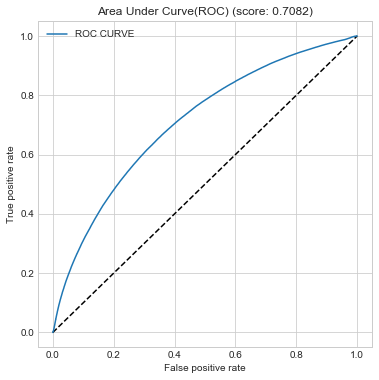

In [60]:
from sklearn.metrics import roc_curve, auc

def draw_roc_curve(y, pred):
    fprRf, tprRf, _ = roc_curve(y, pred, pos_label=1)
    auc_scr = auc(fprRf, tprRf)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.show()
    
draw_roc_curve(vl.target.values, pred)